<h1><center> Analyze_Histograms </center></h1>

**Last Modified**:<br>
By Daniel Baur on 11th March 2019

**Note**:<br>
This notebook `Analyze_Histograms` is used to plot and further examine histograms recorded with the MonXe radon emanation chamber setup.

**Organizing Structure**:<br>
All runs are contained within the folder `Measurements`. A run is defined as a data acquisition session (e.g. 226Ra spectra recorded within one afternoon with a similar setting of parameters), summarizes a few measurements and is referenced with its `runstring` (`runstring` is basically the name of the run folder. It is comprised of a `datestring` in the format YYYYMMDD and a string summarizing the purpose of that specific run.). All of the single measurements within one run are referenced with their corresponding `measurementstring`. Accordingly (most of) the files within the `Measurements` folder follow the following naming scheme: `<runstring>__<measurementstring>`.<br>
Primary datasets (as recorded with the MCA or oscilloscope) also come with a `parameterstring` instead of which processed files usually have a string referring to the origin or purpose of the file. The files `MCAcfg_<datestring>` are the MCA configuration files the primary datasets referr to in their appended `parameterstring`.<br>
(Though this paragraph might have been a little confusing, I reccomend having a look into the respective folders within the `DARWIN_TaskStuff` folder - it'l become clear.



### Table of Contents


0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Global Definitions](#0.2-Global-Definitions)<br>
    0.3 [Formatting](#0.3-Formatting)


1. **[Histograms!](#1.-Histograms!)**<br>
    1.1 [20190307_226Ra_spectrum](#jkdsa)<br>
    1.2 [20190315_226Ra_spectrum](#20190315_226Ra_spectrum)<br>
    1.3 [20190417_222Rn_basement](#20190417_222Rn_basement)<br>


# 0. Stuff

## 0.1 Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import binom as binomcoeff
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.integrate import quad
import datetime
import pprint
import math
from matplotlib.ticker import AutoMinorLocator
import subprocess
from matplotlib.colors import LogNorm
import os
from datetime import date
from random import randint
from scipy.stats import chi2
from scipy.integrate import quad


## 0.2 Global Definitions

### Generic Stuff

In [2]:
def print_datestring():
    return str(date.today().year) + str(date.today().month).zfill(2) + str(date.today().day).zfill(2)

def get_datestring(filestring):
    return filestring[:8]

def get_runstring(filestring):
    runstring = filestring[:filestring.index("__")]
    return runstring

def get_measurementstring(filestring):
    first_two_underscores = filestring.index("__")
    second_two_underscores = filestring[first_two_underscores+2:].index("__") + len(filestring[:first_two_underscores+2])
    return filestring[first_two_underscores+2:second_two_underscores]

def get_parameterstring(filestring):
    first_two_underscores = filestring.index("__")
    second_two_underscores = filestring[first_two_underscores+2:].index("__") + len(filestring[:first_two_underscores+2])
    parameterstring = filestring[second_two_underscores+2:]
    return parameterstring

# Function to read out a certain value from the file name of a np.array file (generated with Signal_Formation()).
def read_out_value_from_string(filestring, parameter_string):
    parameter_index = filestring.index("_" +parameter_string +"_")
    cutoff_index_front = parameter_index +len(parameter_string) +2
    if "_" in filestring[cutoff_index_front:]:
        cutoff_index_back = len(filestring[:cutoff_index_front]) +filestring[cutoff_index_front:].index("_")
        value_string = filestring[cutoff_index_front:cutoff_index_back]
    else:
        value_string = filestring[cutoff_index_front:len(filestring)-4]
    return value_string

# This function is used to read in a histogram.txt file (as recorded with the MCA or the oscilloscope) located in the relative path "filestring".

def save_and_get_histogram_data_as_np_array_from_file(filestring):
    # Defining the initial variables.
    histo_dtype = np.dtype([
        ("adc_channel", np.uint16),
        ("counts", np.uint16),
        ])
    output_tuple_list = []
    # Writing the data from the file to "output_tuple_list".
    try:
        f = open("Measurements/" +get_runstring(filestring) +"/" +filestring)
    except:
        f = open("MonXe/MCA/Measurements/" +get_runstring(filestring) +"/" +filestring)
    for line in f:
        row_tuple = (int(line.strip().split(" ")[0]),int(line.strip().split(" ")[1]))
        output_tuple_list.append(row_tuple)
        #print(row_tuple)
        #else:
            #print(row)
            #NEST_output = [float(row[0]), float(row[1]),  int(row[4]),  int(row[5])]  # order of the NEST output per simulated event: [E [keV],  field [V/cm],  Nph,  Ne-]
            #NEST_output_list.append(NEST_output)
    f.close()
    # Converting and saving "output_tuple_list" to/as np.array into the same directory the original file was retrieved from.
    output_array = np.array(output_tuple_list, histo_dtype)
    try:
        np.save("Measurements/" +get_runstring(filestring) +"/" +filestring[:-4] +".npy", output_array)
    # Returning the name of the np.array file (with precedent directory) so one can easily retrieve the data.
        return "Measurements/" +get_runstring(filestring) +"/" +filestring[:-4] +".npy"
    except:
        np.save("MonXe/MCA/Measurements/" +get_runstring(filestring) +"/" +filestring[:-4] +".npy", output_array)
    # Returning the name of the np.array file (with precedent directory) so one can easily retrieve the data.
        return "MonXe/MCA/Measurements/" +get_runstring(filestring) +"/" +filestring[:-4] +".npy"


    
# This function is used to read in a .txt file generated with https://automeris.io/WebPlotDigitizer/
# The data is then saved in the folder the .txt file was retrieved as a np.array whereas its name is the name of the initial file ending with .npy instead of .txt.
# The output filename is then returned as a string, so one can load the npy.file via
#     $ file = np.load(save_and_get_histogram_data_as_np_array_from_webplot_digitizer_file(filestring))
def save_and_get_histogram_data_as_np_array_from_webplot_digitizer_file(filestring, runstring):
    # Defining the initial variables.
    histo_dtype = np.dtype([
        ("adc_channel", np.float64),
        ("counts", np.float64),
        ])
    output_tuple_list = []
    # Writing the data from the file to "output_tuple_list".
    try:
        f = open("Measurements/" +runstring +"/" +filestring)
    except:
        f = open("MonXe/MCA/Measurements/" +runstring +"/" +filestring)
    for line in f:
        row_tuple = (float(line.strip().split(",")[0]),float(line.strip().split(" ")[1]))
        output_tuple_list.append(row_tuple)
        #print(row_tuple)
        #else:
            #print(row)
            #NEST_output = [float(row[0]), float(row[1]),  int(row[4]),  int(row[5])]  # order of the NEST output per simulated event: [E [keV],  field [V/cm],  Nph,  Ne-]
            #NEST_output_list.append(NEST_output)
    f.close()
    # Converting and saving "output_tuple_list" to/as np.array into the same directory the original file was retrieved from.
    output_array = np.array(output_tuple_list, histo_dtype)
    try:
        np.save("Measurements/" +runstring +"/" +filestring[:-4] +".npy", output_array)
    # Returning the name of the np.array file (with precedent directory) so one can easily retrieve the data.
        return "Measurements/" +runstring +"/" +filestring[:-4] +".npy"
    except:
        np.save("MonXe/MCA/Measurements/" +runstring +"/" +filestring[:-4] +".npy", output_array)
    # Returning the name of the np.array file (with precedent directory) so one can easily retrieve the data.
        return "MonXe/MCA/Measurements/" +runstring +"/" +filestring[:-4] +".npy"



# This function is used to read out the parameters from the txt_filestring of a measurement dataset (e.g. as recorded with the MCA) and convert them into a string that can be plotted directly onto the canvas of the plot.
def write_parameters_to_canvas_text_block(filestring):
    
    # Initializing variables.
    txt_parameterstring = "_" +get_parameterstring(filestring=filestring) 
    printstring = "nooneissupposedtoreadthisanyhowasitisjustusedtopfuschwiththeuseoflatexandpython\\\\[14.0cm]\\textbf{Setup}:\\\\[0.8cm]"
    
    # The "plot_dictionary" dictonary contains various parameters that might occur within the input "filestring" string as keys.
    # Its values are (supposed to be) lists with the following elements:
    # [0]: (string) The name of the parameter as it is supposed to be displayed on the canvas of the plot.
    # [1]: (string) The value of the key string as it is read out from the input "filestring" string.
    # [2]: (string) A string resembling a strange LaTEX/Python3 hybrid that will later on be printed onto the canvas.
    # As [1] and [2] will be appended within the following lines, only [0] can be specified as of now.    
    plot_dictionary = {
        "source":["source: "],
        "readout":["readout: "],
        "coll":["collection voltage: "],
        "bias":["bias voltage: "],
        "amp":["amplifier: "],
        "vessel":["vessel: "],
        "date":["date: ", get_datestring(filestring=filestring), "date: " +get_datestring(filestring=filestring) +"\\\\[0.4cm]"]
    }
    
    # Looping over "plot_dictionary" and appending value[1] and value[2] to value.
    # If the respective key is not part of "txt_filestring", no value is read out and the length of value remains 1 instead of 3.
    for key, value in plot_dictionary.items():
        if key in txt_parameterstring:
            value.append(read_out_value_from_string(filestring=txt_parameterstring, parameter_string=key))
            appendstring = ""
            if key == "source":
                if value[1] == "226Ramasked":
                    appendstring = value[0] +"$^{226}\\mathrm{Ra}$ (masked, in air)" +"\\\\[0.4cm]"
            if key == "readout":
                if value[1][:3] == "MCA":
                    appendstring = value[0] +"MCA " +"(.css file: " +value[1][3:] +")" +"\\\\[0.4cm]"
            if key == "amp":
                if value[1] == "v3.1":
                    appendstring = value[0] +value[1] +"\\\\[0.4cm]"
            if key == "vessel":
                if value[1] == "PastaPot":
                    appendstring = value[0] +value[1] +"\\\\[0.55cm]"
            if key == "coll":
                appendstring = value[0] +"$U_{\\mathrm{coll}}=" +"-" +value[1] +"\\," +"\\mathrm{V}$" +"\\\\[0.4cm]"
            if key == "bias":
                appendstring = value[0] +"$U_{\\mathrm{bias}}=" +value[1] +"\\," +"\\mathrm{V}$" +"\\\\[0.4cm]"
            value.append(appendstring)
        printstring = printstring +value[2]

    return printstring



## 0.3 Formatting

### Using Latex Fonts for Fancy Nancy Plots

In [3]:
# These two lines are used to deploy LaTEX for the Fonts within an output figure.
# note1: All the necessary packages for this should already be imported for your AG Schumann Linux machine by default.
# note2: If you installed jupyter notebook on an external machine install the following packages in advance: $ sudo apt-get install font-manager texlive-latex-extra texlive-math-extra dvipng texlive-fonts-recommended
# note3: Should jupyter notebook throw an "OSError: error reading PNG HEADER" error, try reducing the dpi-value of the image.
%pylab inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Since Latex does interpret "_" as a command to underscore the previous phrase one has to replace it with "\_".
def tex_naming(string):
    latex_string = string.replace("_", "\\_")
    return latex_string

Populating the interactive namespace from numpy and matplotlib


/scratch/lg229/anaconda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.4 Fitting

### Mathematical Functions

In [4]:
# Function to define a gaussian curve with amplitude "A", mean "mu" and sigma "sigma".
def gauss_function(x,A,mu,sigma):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# Function to define a Crystall Ball curve.
# See Stefan Bruenner's Thesis (p.30) for more details.
def crystal_ball_function(x, mu, sigma, alpha, n, N) -> float: # evtl. N als Parameter
    A = (n/abs(alpha))**n *np.exp(-((abs(alpha)**2)/(2)))
    B = (n/abs(alpha)) -abs(alpha)
    if sigma == 0:
        comp_val = 12
    else:
        comp_val = (float(x)-float(mu))/float(sigma)
    #C = (n/abs(alpha)) *(1/(n-1)) *np.exp(-((abs(alpha)**2)/(2)))
    #D = np.sqrt(math.pi/2) *(1 +erf(abs(alpha)/np.sqrt(2)))
    #N = 1/(sigma*(C+D))
    if comp_val > (-1)*alpha:
        return N * np.exp(-(((x-mu)**2)/(2*sigma**2)))
    if comp_val <= (-1)*alpha:
        return N * A* (B - ((x-mu)/(sigma)))**(-n)

# curve_fit() has problems fitting piecewise defined functions, such as crystal_ball_function().
# Online I found, that one has to vectorize the function in order for curve_fit() to be able to fit it properly.
# Here's the corresponding link I found (accessed 12th March 2019): https://stackoverflow.com/questions/11129812/fitting-piecewise-function-in-python
def crystal_ball_function_vec_self(x, mu, sigma, alpha, n, N):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i]=crystal_ball_function(x[i], mu, sigma, alpha, n, N)
    return y



#Function to define a double Crystal Ball curve utilizing the (single) Crystal Ball Curve defined above
def doub_crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1):
    return crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0) + crystal_ball_function(x, mu_1, sigma_1, alpha_1, n_1, N_1)

# curve_fit() has problems fitting piecewise defined functions, such as quad_crystal_ball_function().
# Online I found, that one has to vectorize the function in order for curve_fit() to be able to fit it properly.
# Here's the corresponding link I found (accessed 12th March 2019): https://stackoverflow.com/questions/11129812/fitting-piecewise-function-in-python
def doub_crystal_ball_function_vec_self(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i]=doub_crystal_ball_function(x[i], mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1)
    return y



# Function to define a triple Crystal Ball curve utilizing the (single) Crystal Ball Curve defined above.
def tri_crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2):
    return crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0) +crystal_ball_function(x, mu_1, sigma_1, alpha_1, n_1, N_1) +crystal_ball_function(x, mu_2, sigma_2, alpha_2, n_2, N_2)

# curve_fit() has problems fitting piecewise defined functions, such as tri_crystal_ball_function().
# Online I found, that one has to vectorize the function in order for curve_fit() to be able to fit it properly.
# Here's the corresponding link I found (accessed 12th March 2019): https://stackoverflow.com/questions/11129812/fitting-piecewise-function-in-python
def tri_crystal_ball_function_vec_self(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i]=tri_crystal_ball_function(x[i], mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2)
    return y



# Function to define a quadruple Crystal Ball curve utilizing the (single) Crystal Ball Curve defined above.
def quad_crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3):
    return crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0) +crystal_ball_function(x, mu_1, sigma_1, alpha_1, n_1, N_1) +crystal_ball_function(x, mu_2, sigma_2, alpha_2, n_2, N_2) +crystal_ball_function(x, mu_3, sigma_3, alpha_3, n_3, N_3)

# curve_fit() has problems fitting piecewise defined functions, such as quad_crystal_ball_function().
# Online I found, that one has to vectorize the function in order for curve_fit() to be able to fit it properly.
# Here's the corresponding link I found (accessed 12th March 2019): https://stackoverflow.com/questions/11129812/fitting-piecewise-function-in-python
def quad_crystal_ball_function_vec_self(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i]=quad_crystal_ball_function(x[i], mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3)
    return y



# Function to define a quadruple Crystal Ball curve utilizing the (single) Crystal Ball Curve defined above.
def quint_crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3, mu_4, sigma_4, alpha_4, n_4, N_4):
    return crystal_ball_function(x, mu_0, sigma_0, alpha_0, n_0, N_0) +crystal_ball_function(x, mu_1, sigma_1, alpha_1, n_1, N_1) +crystal_ball_function(x, mu_2, sigma_2, alpha_2, n_2, N_2) +crystal_ball_function(x, mu_3, sigma_3, alpha_3, n_3, N_3) +crystal_ball_function(x, mu_4, sigma_4, alpha_4, n_4, N_4)

# Vectorization of quint_crystal_ball_function()
def quint_crystal_ball_function_vec_self(x, mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3, mu_4, sigma_4, alpha_4, n_4, N_4):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i]=quint_crystal_ball_function(x[i], mu_0, sigma_0, alpha_0, n_0, N_0, mu_1, sigma_1, alpha_1, n_1, N_1, mu_2, sigma_2, alpha_2, n_2, N_2, mu_3, sigma_3, alpha_3, n_3, N_3, mu_4, sigma_4, alpha_4, n_4, N_4)
    return y


### Helpful Functions

In [5]:
# fit_range// function to narrow down a dataset to only fit a certain parameter space
# input//   x,y: lists of the same length representing data
#           x_min, x_max: integer values to whicht the fit parameter space is adapted to
# output//  x_new, y_new: new lists used as basis for the following fit
def fit_range(x,y,x_min, x_max):
    list_beg = x.index(x_min)
    list_end = x.index(x_max)
    x_new = np.zeros(list_end - list_beg + 1)
    y_new = np.zeros(list_end - list_beg + 1)
    for i in range(len(x_new)):
        x_new[i] = x[list_beg+i]
        y_new[i] = y[list_beg+i]
    return x_new, y_new

# This function is used to fit an arbitrary function to a dataset within a specified x value interval.
def fit_range_function(x,y,x_min, x_max, function, guess=0, bounds=0):
    x_new, y_new = fit_range(x,y,x_min, x_max)
    if bounds == 0:
        if guess ==0:
            p_opt, p_cov = curve_fit(function, x_new, y_new, method='lm')  # curve_fit returns x-position, amplitude and sigma to first variable popt
        else:
            p_opt, p_cov = curve_fit(function, x_new, y_new, p0=guess, method='lm')  # curve_fit returns x-position, amplitude and sigma to first variable popt
        return p_opt, p_cov # p_opt carries the fitted parameters for the function specified (in the order as it is specified upon definition).
    if bounds != 0:
        if guess ==0:
            p_opt, p_cov = curve_fit(function, x_new, y_new, bounds=bounds, method='lm')  # curve_fit returns x-position, amplitude and sigma to first variable popt
        else:
            p_opt, p_cov = curve_fit(function, x_new, y_new, p0=guess, bounds=bounds, method='lm')  # curve_fit returns x-position, amplitude and sigma to first variable popt
        return p_opt, p_cov # p_opt carries the fitted parameters for the function specified (in the order as it is specified upon definition).

# This function is used to generate two lists resembling x and y values of a function in a specified interval.
def get_function_values_for_plot(x_min, x_max, stepwidth, function, **kwargs):
    x_list = np.arange(x_min, x_max+stepwidth, stepwidth).tolist()
    y_list = np.zeros_like(x_list).tolist()
    for i in range(len(y_list)):
        y_list[i] = function(x=x_list[i], **kwargs)
    return x_list, y_list


# This function is used to retrieve the energy channel relation utilizing the mean positions (in adc) of two peaks of known energy.
# The inputs "energy_channel_list_1" and "energy_channel_list_1" are list of the form [energy_value, channel_value].
# The function then outputs the adc channel value for the input "energy_value" specified.
def energy_channel_relation(energy_channel_list_high, energy_channel_list_low, energy_value):
    ### Assuming a linear energy_channel_relation the relation E = m*ch+t is used.
    delta_E = energy_channel_list_high[0] - energy_channel_list_low[0]
    delta_ch = energy_channel_list_high[1] - energy_channel_list_low[1]
    m = delta_ch/delta_E
    ### t = E - m*ch
    t = energy_channel_list_high[1] - (m*energy_channel_list_high[0])
    channel_value = m*energy_value +t
    return channel_value

### Fit Analysis

In [6]:
# This is a selfmade chi square test function.
# I wrote it so I could test whether the functions I fitted to a data sample resembled them.
# Note that chi_square is lower (i.e. better), if "number_of_categories" is a divider of "sample_values_max"-"sample_values_min".
def chi_square_test_for_costum_function(sample_values, sample_counts, sample_values_min, sample_values_max, function, number_of_categories=10, significance=0.95, **function_parameters):
    
    # Narrowing down the sample size according to the interval specified by "sample_values_min" and "sample_values_max".
    function_parameters_tuple = ()
    for key, value in function_parameters.items():
        function_parameters_tuple = function_parameters_tuple +(value,)
    mask = (sample_values >= sample_values_min) & (sample_values < sample_values_max)
    sample_values_new = sample_values[mask]
    sample_counts_new = sample_counts[mask]
    total_number_of_counts = sum(sample_counts_new)
    #print(sum(sample_counts))
    #print(total_number_of_counts)
    total_integral = quad(func=function, a=sample_values_min-0.5, b=sample_values_max-0.5, args=function_parameters_tuple)[0]

    # Defining the "number_of_categories"-many categories the sample is divided into.
    category_edges = np.linspace(sample_values_min, sample_values_max, number_of_categories+1, endpoint=True)
    #print(category_edges)
    category_list = []
    
    # Now for all of the categories defined above a tuple containing
    # (index of the category, actual counts within the category, expected counts within the category)
    # is generated and appended to "category_list". Afterwards "category_list" is converted into a np.array.
    for i, low_edge in enumerate(category_edges[:-1]):
        high_edge = category_edges[i+1]-1
        edge_mask = (sample_values_new >= low_edge) & (sample_values_new <= high_edge)
        masked_adc_channels = sample_values_new[edge_mask]
        masked_counts = sample_counts_new[edge_mask]
        actual_counts_in_category = sum(masked_counts)
        partial_integral = quad(func=function, a=low_edge-0.5, b=high_edge+0.5, args=function_parameters_tuple)[0]
        expected_counts_in_category = (partial_integral/total_integral)*total_number_of_counts
        category_tuple = (i, low_edge, high_edge, actual_counts_in_category, expected_counts_in_category)
        category_list.append(category_tuple)
    tuple_dtype = np.dtype([
        ("index", np.uint16),
        ("left_edge", np.float32),
        ("right_edge", np.float32),
        ("actual_counts", np.float32),
        ("expected_counts", np.float32),
    ])
    category_array = np.array(category_list, tuple_dtype)
    #print("total measured: {}".format(sum(sample_counts_new)))
    #print("total measured in array: {}".format(sum(category_array["actual_counts"])))
    #print("total expected in array: {}".format(sum(category_array["expected_counts"])))
    #for i in range(len(category_array["actual_counts"])):
        #print((category_array["actual_counts"][i], category_array["expected_counts"][i]))
    
    # Calculating the chi square value with the scipy.stats.chisquare() function and the critical chi square value (that should not be exceeded) with the  function.
    chi_square = 0
    for i in range(len(category_array["actual_counts"])):
        chi_square = chi_square + (((category_array["actual_counts"][i] -category_array["expected_counts"][i])**2)/(category_array["expected_counts"][i]))
    chi_square_crit = chi2.isf(q=significance, df=number_of_categories-1)
    #chi_square, p = chisquare(f_obs=category_array["actual_counts"], f_exp=["expected_counts"])
    return chi_square, chi_square_crit

# 1. Histograms!

## 1.3   20190417_222Rn_basement

<a id='20190417_222Rn_basement'></a>

No handles with labels found to put in legend.


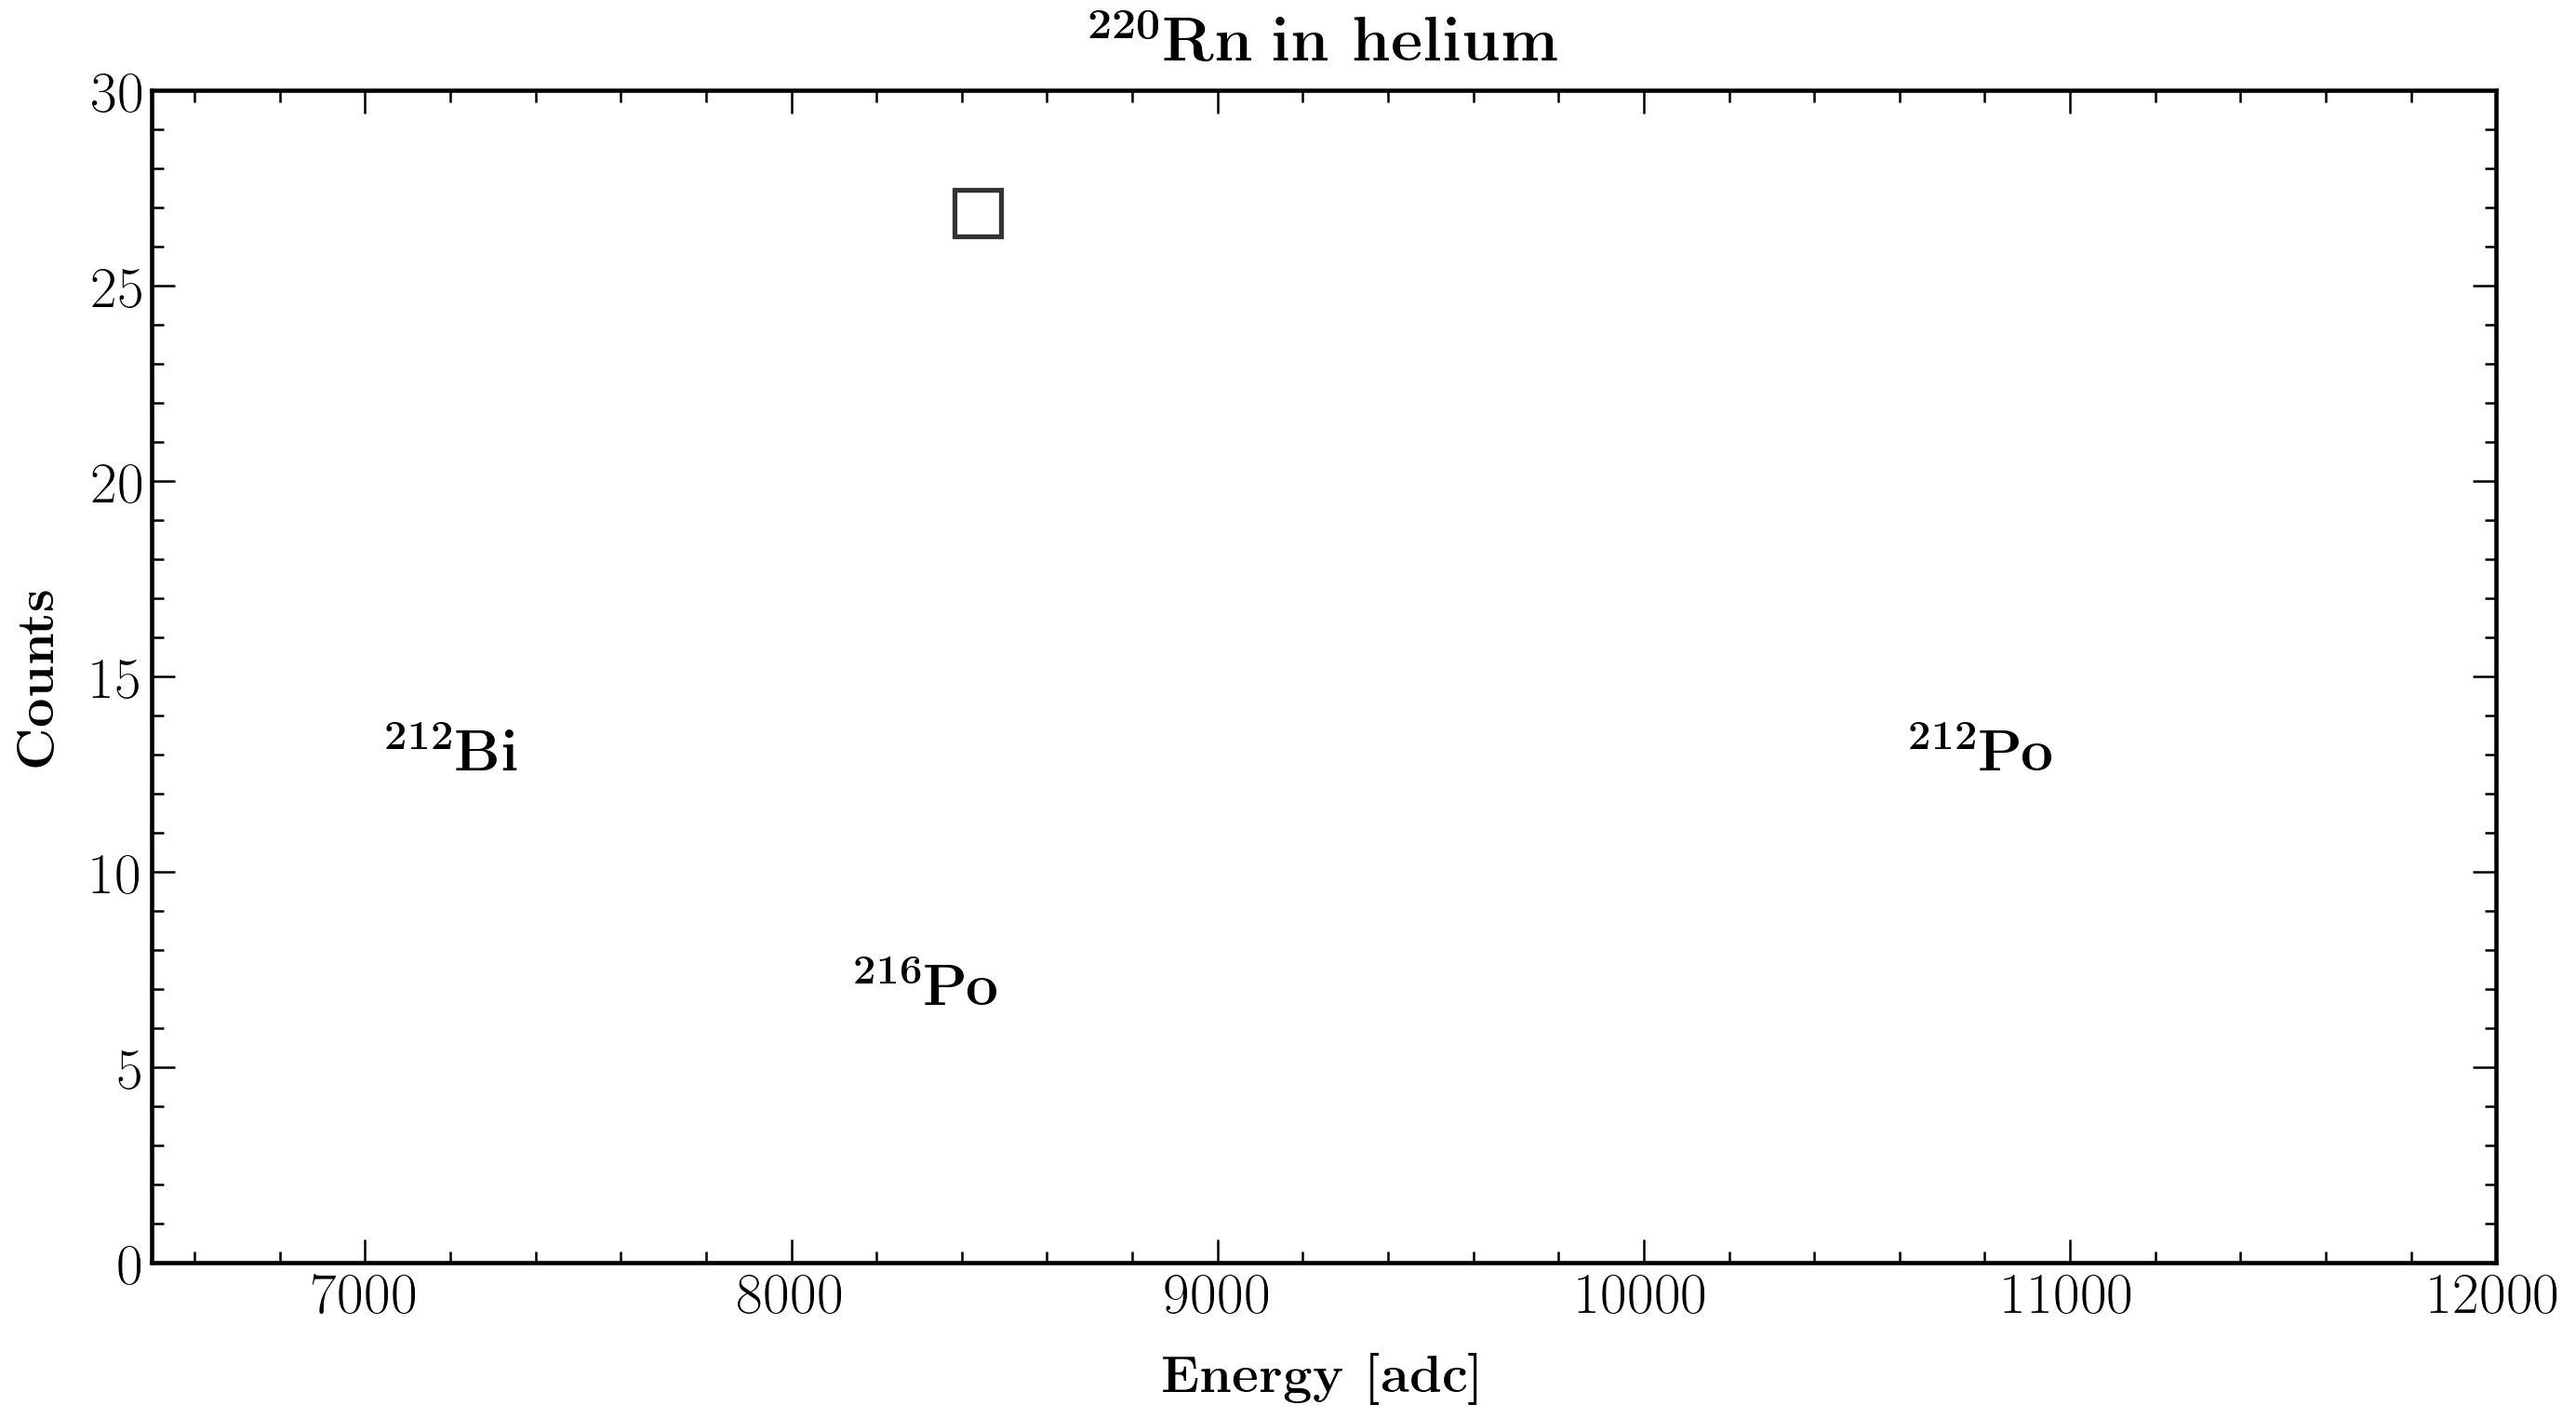

In [18]:

txt_filestring = "20190802_222Rn_Thorium_bottom__220Rn_spectrum__source_basement_readout_MCA20190323_coll_500_bias_9_vessel_PastaPot_amp_v3.2.txt"

FLAG_plot = True

FLAG_fits = False
FLAG_text = False
FLAG_legend = True
FLAG_plot_residual_canvas = False
FLAG_save = False


##################################################################################
###   Loading the .txt File.
##################################################################################

file = np.load(save_and_get_histogram_data_as_np_array_from_file(filestring=txt_filestring))



##################################################################################
###   Fitting
##################################################################################

if FLAG_fits == True:

    ### Gaussian fit.
    #### Fitting.
    #popt_gauss, pcov_gauss = fit_range_function(x=file["adc_channel"].tolist(),y=file["counts"].tolist(),x_min=7300, x_max=7900, function=gauss_function, guess=(1,7300,100))
    #### Generating plottable lists.
    #gauss_fit_x_values, gauss_fit_y_values = get_function_values_for_plot(x_min=6000, x_max=9000, stepwidth=1, function=gauss_function, A=popt_gauss[0], mu=popt_gauss[1], sigma=popt_gauss[2])
    #### Reading out fit parameters.
    #gauss_fit_mu = round(popt_gauss[1],1)
    #gauss_fit_sigma = round(popt_gauss[2],1)

    ### Quad Crystal Ball fit.
    #### Fitting.
    popt_qcb, pcov_qcb = fit_range_function(x=file["adc_channel"].tolist(),y=file["counts"].tolist(),x_min=2000, x_max=12000, function=quad_crystal_ball_function_vec_self, guess=(7600, 180, 1, 1, 125, 8600, 180, 1, 1, 160, 9700, 180, 1, 1, 125, 11200, 180, 1, 1, 125))
    #### Generating plottable data lists.
    qcb_fit_x_values, qcb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=quad_crystal_ball_function, mu_0=popt_qcb[0], sigma_0=popt_qcb[1], alpha_0=popt_qcb[2], n_0=popt_qcb[3], N_0=popt_qcb[4], mu_1=popt_qcb[5], sigma_1=popt_qcb[6], alpha_1=popt_qcb[7], n_1=popt_qcb[8], N_1=popt_qcb[9],mu_2=popt_qcb[10], sigma_2=popt_qcb[11], alpha_2=popt_qcb[12], n_2=popt_qcb[13], N_2=popt_qcb[14],mu_3=popt_qcb[15], sigma_3=popt_qcb[16], alpha_3=popt_qcb[17], n_3=popt_qcb[18], N_3=popt_qcb[19])
    ##### 212Bi Peak
    qcb_fit_mu_0 = round(popt_qcb[0],1)
    qcb_fit_sigma_0 = round(popt_qcb[1],1)
    qcb_fit_alpha_0 = round(popt_qcb[2],1)
    qcb_fit_n_0 = round(popt_qcb[3],1)
    qcb_fit_N_0 = round(popt_qcb[4],1)
    print(qcb_fit_mu_0)
    ##### 216Po Peak
    qcb_fit_mu_1 = round(popt_qcb[5],1)
    qcb_fit_sigma_1 = round(popt_qcb[6],1)
    qcb_fit_alpha_1 = round(popt_qcb[7],1)
    qcb_fit_n_1 = round(popt_qcb[8],1)
    qcb_fit_N_1 = round(popt_qcb[9],1)
    print(qcb_fit_mu_1)
    
    ##### 214Po Peak
    qcb_fit_mu_2 = round(popt_qcb[10],1)
    qcb_fit_sigma_2 = round(popt_qcb[11],1)
    qcb_fit_alpha_2 = round(popt_qcb[12],1)
    qcb_fit_n_2 = round(popt_qcb[13],1)
    qcb_fit_N_2 = round(popt_qcb[14],1)
    print(qcb_fit_mu_2)
    
    ##### 212Po Peak
    qcb_fit_mu_3 = round(popt_qcb[15],1)
    qcb_fit_sigma_3 = round(popt_qcb[16],1)
    qcb_fit_alpha_3 = round(popt_qcb[17],1)
    qcb_fit_n_3 = round(popt_qcb[18],1)
    qcb_fit_N_3 = round(popt_qcb[19],1)
    print(qcb_fit_mu_3)
    
    
    
    #### Generating single Crystal Ball data.
  #  Ra226_cb_fit_x_values, Ra226_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
  #  Rn222_cb_fit_x_values, Rn222_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)
    Bi212_cb_fit_x_values, Bi212_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
    Po216_cb_fit_x_values, Po216_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)
    Po214_cb_fit_x_values, Po214_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_2, sigma=qcb_fit_sigma_2, alpha=qcb_fit_alpha_2, n=qcb_fit_n_2, N=qcb_fit_N_2)
    Po212_cb_fit_x_values, Po212_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_3, sigma=qcb_fit_sigma_3, alpha=qcb_fit_alpha_3, n=qcb_fit_n_3, N=qcb_fit_N_3)


    ### Generating single Gaussian data
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_0, A=5, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_0, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Bi212_x_values, gauss_Bi212_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0)
    
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_1, A=5, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_1, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Po216_x_values, gauss_Po216_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1)
    
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_2, A=5, mu=qcb_fit_mu_2, sigma=qcb_fit_sigma_2)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_2, mu=qcb_fit_mu_2, sigma=qcb_fit_sigma_2, alpha=qcb_fit_alpha_2, n=qcb_fit_n_2, N=qcb_fit_N_2)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Po214_x_values, gauss_Po214_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_2, sigma=qcb_fit_sigma_2)
    
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_3, A=5, mu=qcb_fit_mu_3, sigma=qcb_fit_sigma_3)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_3, mu=qcb_fit_mu_3, sigma=qcb_fit_sigma_3, alpha=qcb_fit_alpha_3, n=qcb_fit_n_3, N=qcb_fit_N_3)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Po212_x_values, gauss_Po212_y_values = get_function_values_for_plot(x_min=1000, x_max=12000, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_3, sigma=qcb_fit_sigma_3)


    

    
    
    ### Generating residual data
    res_x_data = []
    res_y_data = []
    for i in range(len(file["adc_channel"])):
        res_x_data.append(file["adc_channel"][i])
        res_y_data.append(file["counts"][i]-doub_crystal_ball_function(x=file["adc_channel"][i], mu_0=qcb_fit_mu_0, sigma_0=qcb_fit_sigma_0, alpha_0=qcb_fit_alpha_0, n_0=qcb_fit_n_0, N_0=qcb_fit_N_0, mu_1=qcb_fit_mu_1, sigma_1=qcb_fit_sigma_1, alpha_1=qcb_fit_alpha_1, n_1=qcb_fit_n_1, N_1=qcb_fit_N_1))



##################################################################################
###   Plotting.
##################################################################################

if FLAG_plot == True:

    #######################################################################################################################################
    ###   Defining Figure and Frame
    #######################################################################################################################################
    
    fig=plt.figure(figsize=(21, 10.5), dpi=150)  # <----- The number specified within "figsize=()" correspond to the size of the final image in inches. Correspondingly the dpi (dots per inch) value is setting the resolution of your figure.
    if FLAG_plot_residual_canvas == True:
        frame1=fig.add_axes((.1,.3,.8,.6)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))
    else: 
        frame1=fig.add_axes((.1,.1,.8,.8)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))

    #######################################################################################################################################
    ###   Plotting Data
    #######################################################################################################################################
    
    ### Plotting histogram, scatter plot or line plot.
    plt.hist2d(file["adc_channel"], file["counts"], bins=[1,1], range=[[0,142],[0.5,40]], cmin=1, norm=LogNorm(), cmap=plt.cm.jet)
    #plt.scatter(file["S1_PE"], file["S2_PE"], marker="o", c="cyan", alpha=1, label="equally distributed ER events") # alpha = 0.002    
    #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Quadruple Crystal Ball Fit")
        
    ### Plotting the data itself.
    #plt.scatter(file["adc_channel"], file["counts"], bins = [10,5], marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None, label="$^{224}\mathrm{Ra}$ Spectrum Data")
    
    if FLAG_fits == True:
        
        ### Plotting the quadruple Crystal Ball fit.
        #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Quadruple Crystal Ball Fit")
    
        ### Plotting the Crystal Ball curves resulting from the quadruple Crystal Ball fit.
        #plt.plot(Ra226_cb_fit_x_values, Ra226_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{226}\mathrm{Ra}$")
        #plt.plot(Rn222_cb_fit_x_values, Rn222_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{222}\mathrm{Rn}$")
        plt.plot(Bi212_cb_fit_x_values, Bi212_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{212}\mathrm{Bi}$")
        plt.plot(Po216_cb_fit_x_values, Po216_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{216}\mathrm{Po}$")
        plt.plot(Po214_cb_fit_x_values, Po214_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{214}\mathrm{Po}$")
        plt.plot(Po212_cb_fit_x_values, Po212_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{212}\mathrm{Po}$")
    
    
    
        ### Plotting the relevant gaussians resulting from the quadruple Crystal Ball fit.
        plt.plot(gauss_Bi212_x_values, gauss_Bi212_y_values, marker=",", linewidth=5, c="blue", alpha=0.75, label="Gaussian Curve: $^{212}\mathrm{Bi}$")
        plt.plot(gauss_Po216_x_values, gauss_Po216_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{216}\mathrm{Po}$")
        plt.plot(gauss_Po214_x_values, gauss_Po214_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{214}\mathrm{Po}$")
        plt.plot(gauss_Po212_x_values, gauss_Po212_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{212}\mathrm{Po}$")
        
        
        
    
        ### Plotting a gaussian fit for the 214Po Peak (the fit is done only for the right half).
        #plt.plot(gauss_fit_x_values, gauss_fit_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Fit: $\mu_\mathrm{G}=\,$" +str(gauss_fit_mu) +"$,\,\,\sigma_\mathrm{G}=\,$" +str(gauss_fit_sigma))
     
    
    #######################################################################################################################################
    ###   Axes Settings
    #######################################################################################################################################
    
    ### Title
    title_string = "$\\boldsymbol{^{220}\mathrm{Rn}}$ \\textbf{in helium}"
    plt.title(title_string, fontsize=32, pad=15)
    
    ### Axes ---> Labels
        #plt.xlabel("\\textbf{$\\boldsymbol{F=ma}$}", fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    xaxisstring = "\\textbf{Energy }$\\boldsymbol{[\\mathrm{adc}]}$"
    yaxisstring = "\\textbf{Counts}"
    if FLAG_plot_residual_canvas == True:
        plt.xlabel(xaxisstring, fontsize=27, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    else:
        plt.xlabel(xaxisstring, fontsize=27, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    plt.ylabel(yaxisstring, fontsize=27, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    
    ### Axes ---> Formatting
    axes = plt.gca()
    axes.tick_params(axis='both')
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)
        
    ### Axes ---> Range  
    plt.xlim(6500,12000)
    plt.ylim(0,30)
    #plt.ylim(100,2500)
    #plt.yscale("log")
    
    ### Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=30, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='major', direction='in', labelsize=30, top=True, right=True, width=1.2, length=12)
    if FLAG_plot_residual_canvas == True:
        plt.setp(axes.get_xticklabels(), visible=False)
    #plt.yticks([1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0, 5.0])
    #plt.xticks([])
    
    plt.text(0.75, 0.42, "$\\boldsymbol{^{212}\mathrm{Po}}$", fontsize=30, transform = axes.transAxes)
    plt.text(0.10, 0.42, "$\\boldsymbol{^{212}\mathrm{Bi}}$", fontsize=30, transform = axes.transAxes)
    plt.text(0.30, 0.22, "$\\boldsymbol{^{216}\mathrm{Po}}$", fontsize=30, transform = axes.transAxes)
    
    
    ### Axes ---> Shading
    #axes.axvspan(0, 23.0, alpha=0.5, color='0.8')
    
    ### Axes ---> Horizontal/Vertical Lines
    #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
    #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)

    #######################################################################################################################################
    ###   Colorbar
    #######################################################################################################################################
    
    #cbar = plt.colorbar() #label="Counts") #, fontsize=28)
    #cbar.set_label(label="Counts", fontsize=24, labelpad=-105)
    #cbar.outline.set_linewidth(2.2)
    #cbar.ax.tick_params(labelsize=20)

    #######################################################################################################################################
    ###   Plot Size
    #######################################################################################################################################
    
    # For a figure optimized for 4:3 ratio.
    plt.subplots_adjust(left=0.10, right=0.80, top=0.93, bottom=0.10)
    # For a figure optimized for 16:9 ratio.
    #plt.subplots_adjust(left=0.05, right=1.10, top=0.93, bottom=0.10)

    #######################################################################################################################################
    ###   Legend
    #######################################################################################################################################
    
    if FLAG_legend == True:
    
        if FLAG_plot_residual_canvas == True:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [5,0,1,3,2,4]
            leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=3, bbox_to_anchor=(0.69,0.51), fontsize = 18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
        else:
            leg = plt.legend(loc=3, bbox_to_anchor=(0.33,0.85), fontsize=30, frameon=True, shadow=False, edgecolor='black', fancybox=False)
            
        for line in leg.get_lines(): # enumerated
            line.set_linewidth(4)
        leg.get_frame().set_linewidth(2.5)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    #######################################################################################################################################
    ###   Text
    #######################################################################################################################################
    
        
    #plt.text(0.25, 0.42, "$^{218}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
    #plt.text(0.83, 0.42, "$^{214}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
        
    if FLAG_text == True:
        if FLAG_plot_residual_canvas == True:
            plt.text(0.02, 0.30, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
        else:
            plt.text(0.02, 0.450, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
        
    #######################################################################################################################################
    ###   Residual Canvas
    #######################################################################################################################################
    
    if FLAG_plot_residual_canvas == True:
        frame2=fig.add_axes((.1,.1,.8,.2))
    
        # Plotting
        plt.scatter(res_x_data, res_y_data, marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None)#, label="Residuals")
    
        # Axes Settings
        plt.ylabel("\\textbf{Residuals}", fontsize=24, labelpad = 9)   # <--- Specifying the x-axis label along with its (self explaining) properties.
        axes2 = plt.gca()
        axes2.tick_params(axis='both')
        for axis in ['top','bottom','left','right']:
            axes2.spines[axis].set_linewidth(2.2)
        ## Axes ---> Range  
        plt.xlim(1000,12000)
        plt.ylim(-150,+150)
        #plt.yscale("log")
        # Axes ---> Ticks
        axes2.xaxis.set_minor_locator(AutoMinorLocator(5))
        #plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
        axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
        plt.tick_params(which='major', direction='in', labelsize=23, top=True, right=True, width=1.2, length=12)
        plt.yticks([-100,0,100])
        #plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
        # Axes ---> Shading
        #axes.axvspan(0, 23.0, alpha=0.5, color='0.8')
        # Axes ---> Horizontal/Vertical Lines
        #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
        #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)
        axes2.axhline(y=0.0, xmin=0, xmax=10000, color="black", linestyle="--", linewidth=2.0)
        
        
        
    
        
        ### Printing Analysis Results
 #   print("Fit Data for the 218Po Peak: mu_0={}adc, sigma_0={}adc, alpha_0={}, n_0={}, N_0={}".format(qcb_fit_mu_0, qcb_fit_sigma_0, qcb_fit_alpha_0, qcb_fit_n_0, qcb_fit_N_0))
  #  print("Fit Data for the 214Po Peak: mu_1={}adc, sigma_1={}adc, alpha_1={}, n_1={}, N_1={}".format(qcb_fit_mu_1, qcb_fit_sigma_1, qcb_fit_alpha_1, qcb_fit_n_1, qcb_fit_N_1))
   # print("Fit Data for the 214Po Peak: mu_2={}adc, sigma_2={}adc, alpha_2={}, n_2={}, N_2={}".format(qcb_fit_mu_2, qcb_fit_sigma_2, qcb_fit_alpha_2, qcb_fit_n_2, qcb_fit_N_2))
    #print("Fit Data for the 214Po Peak: mu_3={}adc, sigma_3={}adc, alpha_3={}, n_3={}, N_3={}".format(qcb_fit_mu_3, qcb_fit_sigma_3, qcb_fit_alpha_3, qcb_fit_n_3, qcb_fit_N_3))
    
    
    #######################################################################################################################################
    ###   Saving
    #######################################################################################################################################
    
    if FLAG_save == True:
        save_string = "spectrum_fit"
        format_string = ".png"
        fig.savefig("MonXe/MCA/Measurements/" +get_runstring(filestring=txt_filestring) +"/" +get_runstring(filestring=txt_filestring) +"__" +get_measurementstring(filestring=txt_filestring) +"__" +save_string +format_string)

In [10]:
FWHM= 2*np.sqrt(2*np.log(2))*qcb_fit_sigma_0
print('FWHM:',FWHM)
R=(FWHM/qcb_fit_mu_1)
print('Auflösung:',R)

FWHM: 167.6631872062036
Auflösung: 0.019538659053758095


In [27]:
begin_218_1000 = round(qcb_fit_mu_0-3*np.sqrt(qcb_fit_sigma_0**2))
end_218_1000 = round(qcb_fit_mu_0+2*np.sqrt(qcb_fit_sigma_0**2))
begin_216_1000 = round(qcb_fit_mu_1-3*np.sqrt(qcb_fit_sigma_1**2))
end_216_1000 = round(qcb_fit_mu_1+2*np.sqrt(qcb_fit_sigma_1**2))
begin_214_1000 = round(qcb_fit_mu_2-3*np.sqrt(qcb_fit_sigma_2**2))
end_214_1000 = round(qcb_fit_mu_2+2*np.sqrt(qcb_fit_sigma_2**2))
begin_212_1000 = round(qcb_fit_mu_3-3*np.sqrt(qcb_fit_sigma_3**2))
end_212_1000 = round(qcb_fit_mu_3+2*np.sqrt(qcb_fit_sigma_3**2))

Bi = sum(file["counts"][int(begin_218_1000):int(end_218_1000)])
Po = sum(file["counts"][int(begin_212_1000):int(end_212_1000)])




print("1000V")
print("Counts of the Bi212 peak: {}".format(sum(file["counts"][int(begin_218_1000):int(end_218_1000)])))
print("Counts of the Po216 peak: {}".format(sum(file["counts"][int(begin_216_1000):int(end_216_1000)])))
print("Counts of the Po214 peak: {}".format(sum(file["counts"][int(begin_214_1000):int(end_214_1000)])))
print("Counts of the Po212 peak: {}".format(sum(file["counts"][int(begin_212_1000):int(end_212_1000)])))

errBi = np.sqrt((Bi))
errPo = np.sqrt(Po)
print(errBi)
print(errPo)

Po2=Po**2
dPo = (Bi/(Po2))**2
dBi = (1/Po)**2
print((Bi/Po2)**2)
err = np.sqrt(dPo*errBi**2+dBi*errPo**2)
err = np.sqrt((((1/Po)**2)*(errBi**2))+((Bi/(Po**2))**2)*(errPo**2))


print("Fehler:{}".format(err))


b = Bi/Po
print("Verhältnis Messung: {}".format(b))
a = 36/64
print("Verhältnis Literatur: {}".format(a))

#print("Counts of the Po218 peak in minutes: {}".format(sum(file["counts"][int(begin_218_1000):int(end_218_1000)])/3834))
#print("Counts of the Po214 peak in minutes: {}".format(sum(file["counts"][int(begin_214_1000):int(end_214_1000)])/3834))


1000V
Counts of the Bi212 peak: 2597
Counts of the Po216 peak: 503
Counts of the Po214 peak: 42
Counts of the Po212 peak: 4586
50.96076922496363
67.72001181334805
1.5247817935219685e-08
Fehler:0.013907140186432673
Verhältnis Messung: 0.5662887047535979
Verhältnis Literatur: 0.5625


FWHM: 148.5891448414529
Auflösung: 1.7315862167024378


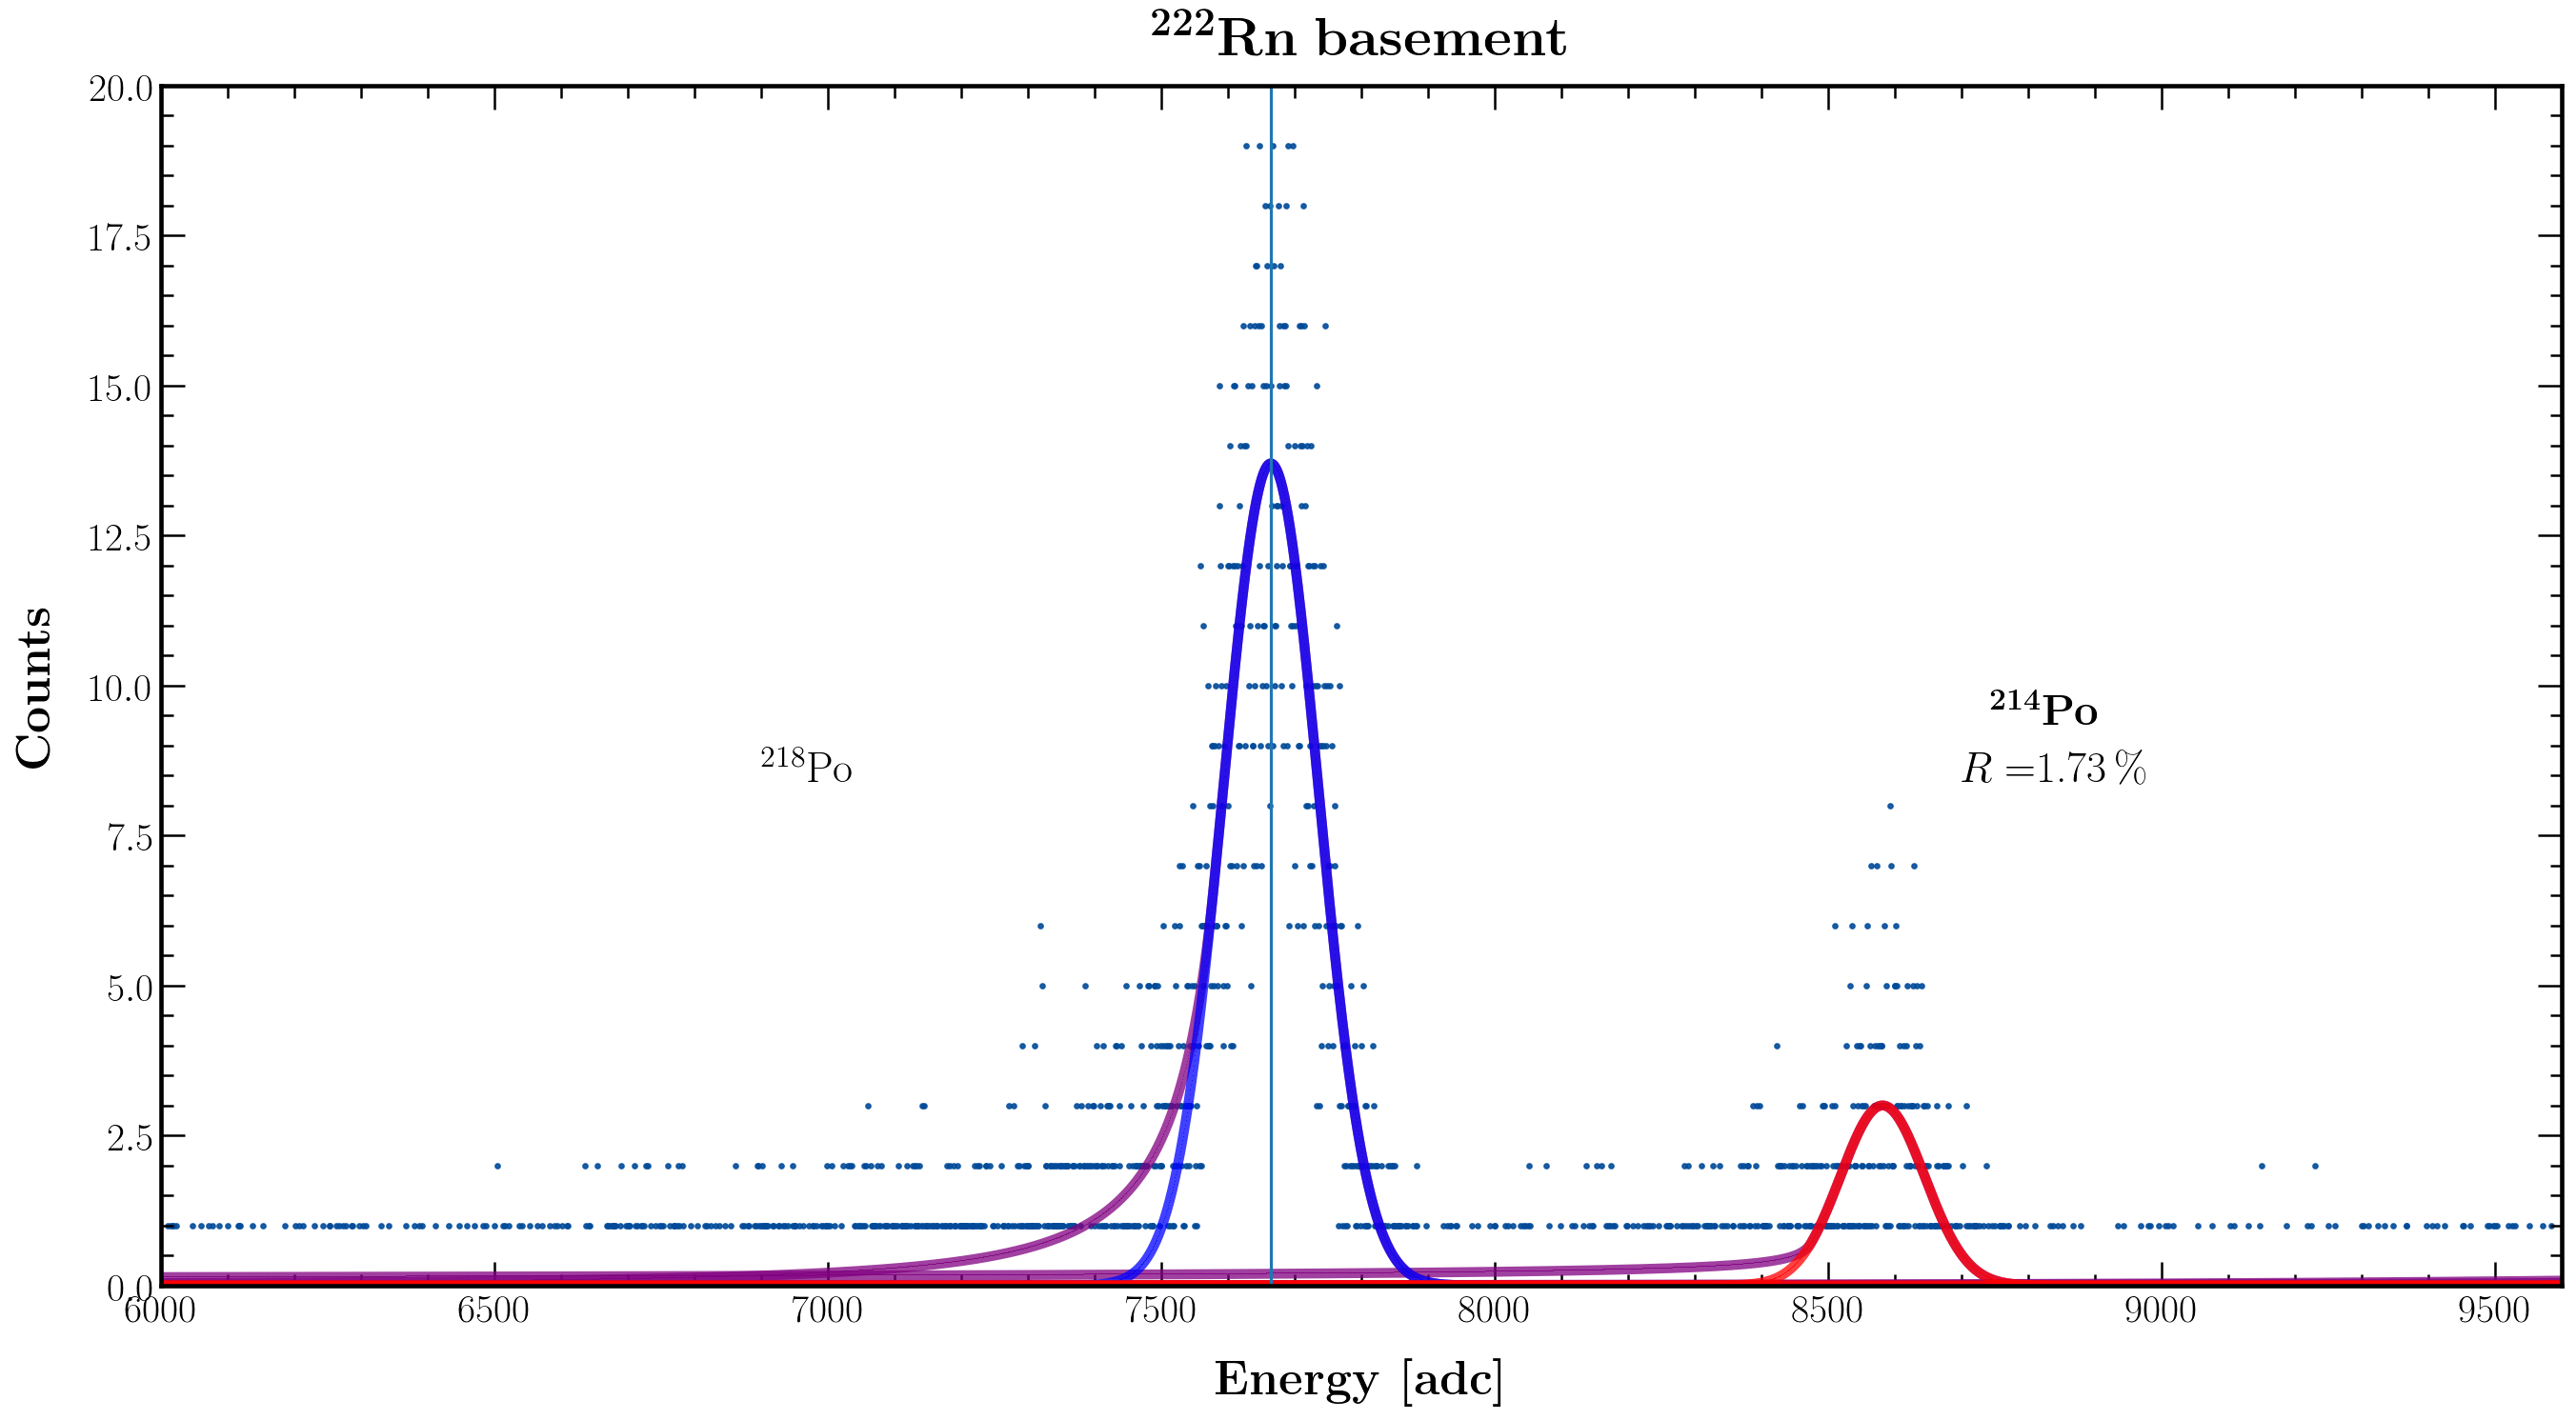

In [27]:
    ### Energy Channel Relation
    #### The energy channel relation within these few lines of code are inferred solely from the 214Po and 218Po peaks.
    #### The reasonning behind this is to check, whether the peaks of 226Ra and 222Rn show up where one would expect them to.
    
    energy_212Bi_alpha = 7663.8
    energy_216Po_alpha = 8581.1
    energy_214Po_alpha = 9745.5
    energy_212Po_alpha = 11189.5

    
    energy_channel_212Bi_alpha = [energy_212Bi_alpha, qcb_fit_mu_0]
    energy_channel_216Po_alpha = [energy_216Po_alpha, qcb_fit_mu_1]
    energy_channel_214Po_alpha = [energy_214Po_alpha, qcb_fit_mu_2]
    energy_channel_212Po_alpha = [energy_212Po_alpha, qcb_fit_mu_3]
    

    
    ch_value_212Bi = energy_channel_relation(energy_channel_list_high=energy_channel_214Po_alpha, energy_channel_list_low=energy_channel_212Bi_alpha, energy_value=energy_212Bi_alpha)
    ch_value_216Po = energy_channel_relation(energy_channel_list_high=energy_channel_214Po_alpha, energy_channel_list_low=energy_channel_212Bi_alpha, energy_value=energy_214Po_alpha)
    ch_value_214Po = energy_channel_relation(energy_channel_list_high=energy_channel_214Po_alpha, energy_channel_list_low=energy_channel_212Bi_alpha, energy_value=energy_214Po_alpha)
    ch_value_212Po = energy_channel_relation(energy_channel_list_high=energy_channel_214Po_alpha, energy_channel_list_low=energy_channel_212Bi_alpha, energy_value=energy_214Po_alpha)
    
    
    
   

     
    ##################################################################################
    ###   Plotting.
    ##################################################################################

    FLAG_plot = True
    if FLAG_plot == True:
        
        #######################################################################################################################################
        ###   Defining Figure and Frame
        #######################################################################################################################################
        
        fig=plt.figure(figsize=(21, 10.5), dpi=150)  ### <----- The number specified within "figsize=()" correspond to the size of the final image in inches. Correspondingly the dpi (dots per inch) value is setting the resolution of your figure.
    
        
        if FLAG_plot_residual_canvas == True:
            print("daniel was here")
            frame1=fig.add_axes((.1,.3,.8,.6)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))
        else:
            frame1=fig.add_axes((.1,.1,.8,.8)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))
    
    #######################################################################################################################################
    ###   Plotting Data
    #######################################################################################################################################
    
    ### Plotting histogram, scatter plot or line plot.
    #plt.hist2d(file_a["number_of_electrons"], file_a["S1_PE"], bins=[142,40], range=[[0,142],[0.5,40]], cmin=1, norm=LogNorm(), cmap=plt.cm.jet)
    #plt.scatter(file["S1_PE"], file["S2_PE"], marker="o", c="cyan", alpha=1, label="equally distributed ER events") # alpha = 0.002    
    #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Quadruple Crystal Ball Fit")
        
    ### Plotting the data itself.
    plt.scatter(file["adc_channel"], file["counts"], marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None, label="$^{222}\mathrm{Rn}$ Spectrum Data")
    
    if FLAG_fits == True:
        
        ### Plotting the quadruple Crystal Ball fit.
        #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Quadruple Crystal Ball Fit")
    
        ### Plotting the Crystal Ball curves resulting from the quadruple Crystal Ball fit.
       
        #plt.plot(Po218_cb_fit_x_values, Po218_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{218}\mathrm{Po}$")
        #plt.plot(Po214_cb_fit_x_values, Po214_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{214}\mathrm{Po}$")
    
        ### Plotting the relevant gaussians resulting from the quadruple Crystal Ball fit.
        #plt.plot(gauss_Po218_x_values, gauss_Po218_y_values, marker=",", linewidth=5, c="blue", alpha=0.75, label="Gaussian Curve: $^{218}\mathrm{Po}$")
        #plt.plot(gauss_Po214_x_values, gauss_Po214_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{214}\mathrm{Po}$")
    
        ### Plotting a gaussian fit for the 214Po Peak (the fit is done only for the right half).
        #plt.plot(gauss_fit_x_values, gauss_fit_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Fit: $\mu_\mathrm{G}=\,$" +str(gauss_fit_mu) +"$,\,\,\sigma_\mathrm{G}=\,$" +str(gauss_fit_sigma))
     
    
        plt.plot(Bi212_cb_fit_x_values, Bi212_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{212}\mathrm{Bi}$")
        plt.plot(Po216_cb_fit_x_values, Po216_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{216}\mathrm{Po}$")
        plt.plot(Po214_cb_fit_x_values, Po214_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{214}\mathrm{Po}$")
        plt.plot(Po212_cb_fit_x_values, Po212_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{212}\mathrm{Po}$")
    
    
    
        ### Plotting the relevant gaussians resulting from the quadruple Crystal Ball fit.
        plt.plot(gauss_Bi212_x_values, gauss_Bi212_y_values, marker=",", linewidth=5, c="blue", alpha=0.75, label="Gaussian Curve: $^{212}\mathrm{Bi}$")
        plt.plot(gauss_Po216_x_values, gauss_Po216_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{216}\mathrm{Po}$")
        plt.plot(gauss_Po214_x_values, gauss_Po214_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{214}\mathrm{Po}$")
        plt.plot(gauss_Po212_x_values, gauss_Po212_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{212}\mathrm{Po}$")
    
    
    
    
    #######################################################################################################################################
    ###   Axes Settings
    #######################################################################################################################################
    
    ### Title
    title_string = "$\\boldsymbol{^{222}\mathrm{Rn}}$ \\textbf{basement}"
    plt.title(title_string, fontsize=28, pad=15)
    
    ### Axes ---> Labels
        #plt.xlabel("\\textbf{$\\boldsymbol{F=ma}$}", fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    xaxisstring = "\\textbf{Energy }$\\boldsymbol{[\\mathrm{adc}]}$"
    yaxisstring = "\\textbf{Counts}"
    if FLAG_plot_residual_canvas == True:
        plt.xlabel(xaxisstring, fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    else:
        plt.xlabel(xaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    plt.ylabel(yaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    
    ### Axes ---> Formatting
    axes = plt.gca()
    axes.tick_params(axis='both')
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)
        
    ### Axes ---> Range  
    plt.xlim(6000,9600) #plt.xlim(0,8500)
    plt.ylim(0,20)
    #plt.ylim(100,2500)
    #plt.yscale("log")
    
    ### Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='major', direction='in', labelsize=20, top=True, right=True, width=1.2, length=12)
    if FLAG_plot_residual_canvas == True:
        plt.setp(axes.get_xticklabels(), visible=False)
    #plt.yticks([1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0, 5.0])
    #plt.xticks([])
    
    ### Axes ---> Shading
    plt.axvline(x=ch_value_212Bi)
    plt.axvline(x=ch_value_216Po)
    plt.axvline(x=ch_value_214Po)
    plt.axvline(x=ch_value_212Po)
    
    
    
    #axes.axvspan(ch_value_218Po-50, ch_value_218Po+50, alpha=0.5, color='0.8')
    #axes.axvspan(ch_value_214Po-50, ch_value_214Po+50, alpha=0.5, color='0.8')
    
    ### Axes ---> Horizontal/Vertical Lines
    #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
    #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)
    
    #######################################################################################################################################
    ###   Colorbar
    #######################################################################################################################################
    
    #cbar = plt.colorbar() #label="Counts") #, fontsize=28)
    #cbar.set_label(label="Counts", fontsize=24, labelpad=-105)
    #cbar.outline.set_linewidth(2.2)
    #cbar.ax.tick_params(labelsize=20)

    #######################################################################################################################################
    ###   Plot Size
    #######################################################################################################################################
    
    # For a figure optimized for 4:3 ratio.
    plt.subplots_adjust(left=0.10, right=0.80, top=0.93, bottom=0.10)
    # For a figure optimized for 16:9 ratio.
    #plt.subplots_adjust(left=0.05, right=1.10, top=0.93, bottom=0.10)

    #######################################################################################################################################
    ###   Legend
    #######################################################################################################################################
    
    if FLAG_legend == True:
    
        if FLAG_plot_residual_canvas == True:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [5,0,1,3,2,4]
            leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=3, bbox_to_anchor=(0.69,0.51), fontsize = 18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
        else:
            leg = plt.legend(loc=3, bbox_to_anchor=(0.60,0.71), fontsize=18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
            
        for line in leg.get_lines(): # enumerated
            line.set_linewidth(4)
        leg.get_frame().set_linewidth(2.5)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
            
            
    #######################################################################################################################################
    ###    Resolution
    #######################################################################################################################################

    
    FWHM= 2*np.sqrt(2*np.log(2))*qcb_fit_sigma_1
    print('FWHM:',FWHM)

    R=(FWHM/qcb_fit_mu_1)
    resolution_channel = R*100


    print('Auflösung:',resolution_channel)
    
    
    
    #######################################################################################################################################
    ###   Text
    #######################################################################################################################################
    
    plt.text(0.25, 0.42, "$^{218}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
    #plt.text(0.83, 0.42, "$^{214}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
    plt.text(0.75, 0.42, "$\\boldsymbol{^{214}\mathrm{Po}}$" +"\\\\[0.4cm]" +"$\\,\\,\\,\\,\\,R=$" +"{:.2f}".format(resolution_channel) +"$\\,\\%$", fontsize=22, transform = axes.transAxes)  
        
        
    if FLAG_text == True:
        if FLAG_plot_residual_canvas == True:
            plt.text(0.02, 0.30, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
        else:
            plt.text(0.02, 0.450, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
    #######################################################################################################################################
    ###   Residual Canvas
    #######################################################################################################################################
    
    if FLAG_plot_residual_canvas == True:
        frame2=fig.add_axes((.1,.1,.8,.2))
    
        # Plotting
        plt.scatter(res_x_data, res_y_data, marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None)#, label="Residuals")
    
        # Axes Settings
        plt.ylabel("\\textbf{Residuals} $[\\mathrm{\\sigma}]$", fontsize=24, labelpad = 9)   # <--- Specifying the x-axis label along with its (self explaining) properties.
        axes2 = plt.gca()
        axes2.tick_params(axis='both')
        for axis in ['top','bottom','left','right']:
            axes2.spines[axis].set_linewidth(2.2)
        ## Axes ---> Range  
        plt.xlim(2000,8500)
        plt.ylim(-4,+4)
        #plt.yscale("log")
        # Axes ---> Ticks
        axes2.xaxis.set_minor_locator(AutoMinorLocator(5))
        plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
        axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
        plt.tick_params(which='major', direction='in', labelsize=20, top=True, right=True, width=1.2, length=12)
        plt.yticks([-3,0,3])
        #plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
        # Axes ---> Shading
        #axes.axvspan(0, 23.0, alpha=0.5, color='0.8')
        # Axes ---> Horizontal/Vertical Lines
        #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
        #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)
        axes2.axhline(y=0.0, xmin=0, xmax=10000, color="black", linestyle="--", linewidth=2.0)
    
    
    #######################################################################################################################################
    ###   Saving
    #######################################################################################################################################
    
    if FLAG_save == True:
        save_string = "spectrum_fits_res"
        format_string = ".png"
        #fig.savefig("MonXe/MCA/MCA/Measurements/test.png")

        fig.savefig("MonXe/MCA/Measurements/" +get_runstring(filestring=txt_filestring) +"/" +get_runstring(filestring=txt_filestring) +"__" +get_measurementstring(filestring=txt_filestring) +"__" +save_string +format_string)


In [12]:
FWHM= 2*np.sqrt(2*np.log(2))*qcb_fit_sigma_1
print('FWHM:',FWHM)
R=(FWHM/qcb_fit_mu_1)
print('Auflösung:',R)
printstring = "Auflösung = {}".format(R)
print(printstring)

FWHM: 84.53803961661107
Auflösung: 0.00912661825977146
Auflösung = 0.00912661825977146


Fit Data for the 218Po Peak: mu_0=7078.3adc, sigma_0=31.2adc, alpha_0=0.8, n_0=2.5, N_0=312.4
Fit Data for the 214Po Peak: mu_1=9084.0adc, sigma_1=31.3adc, alpha_1=0.8, n_1=3.1, N_1=571.0


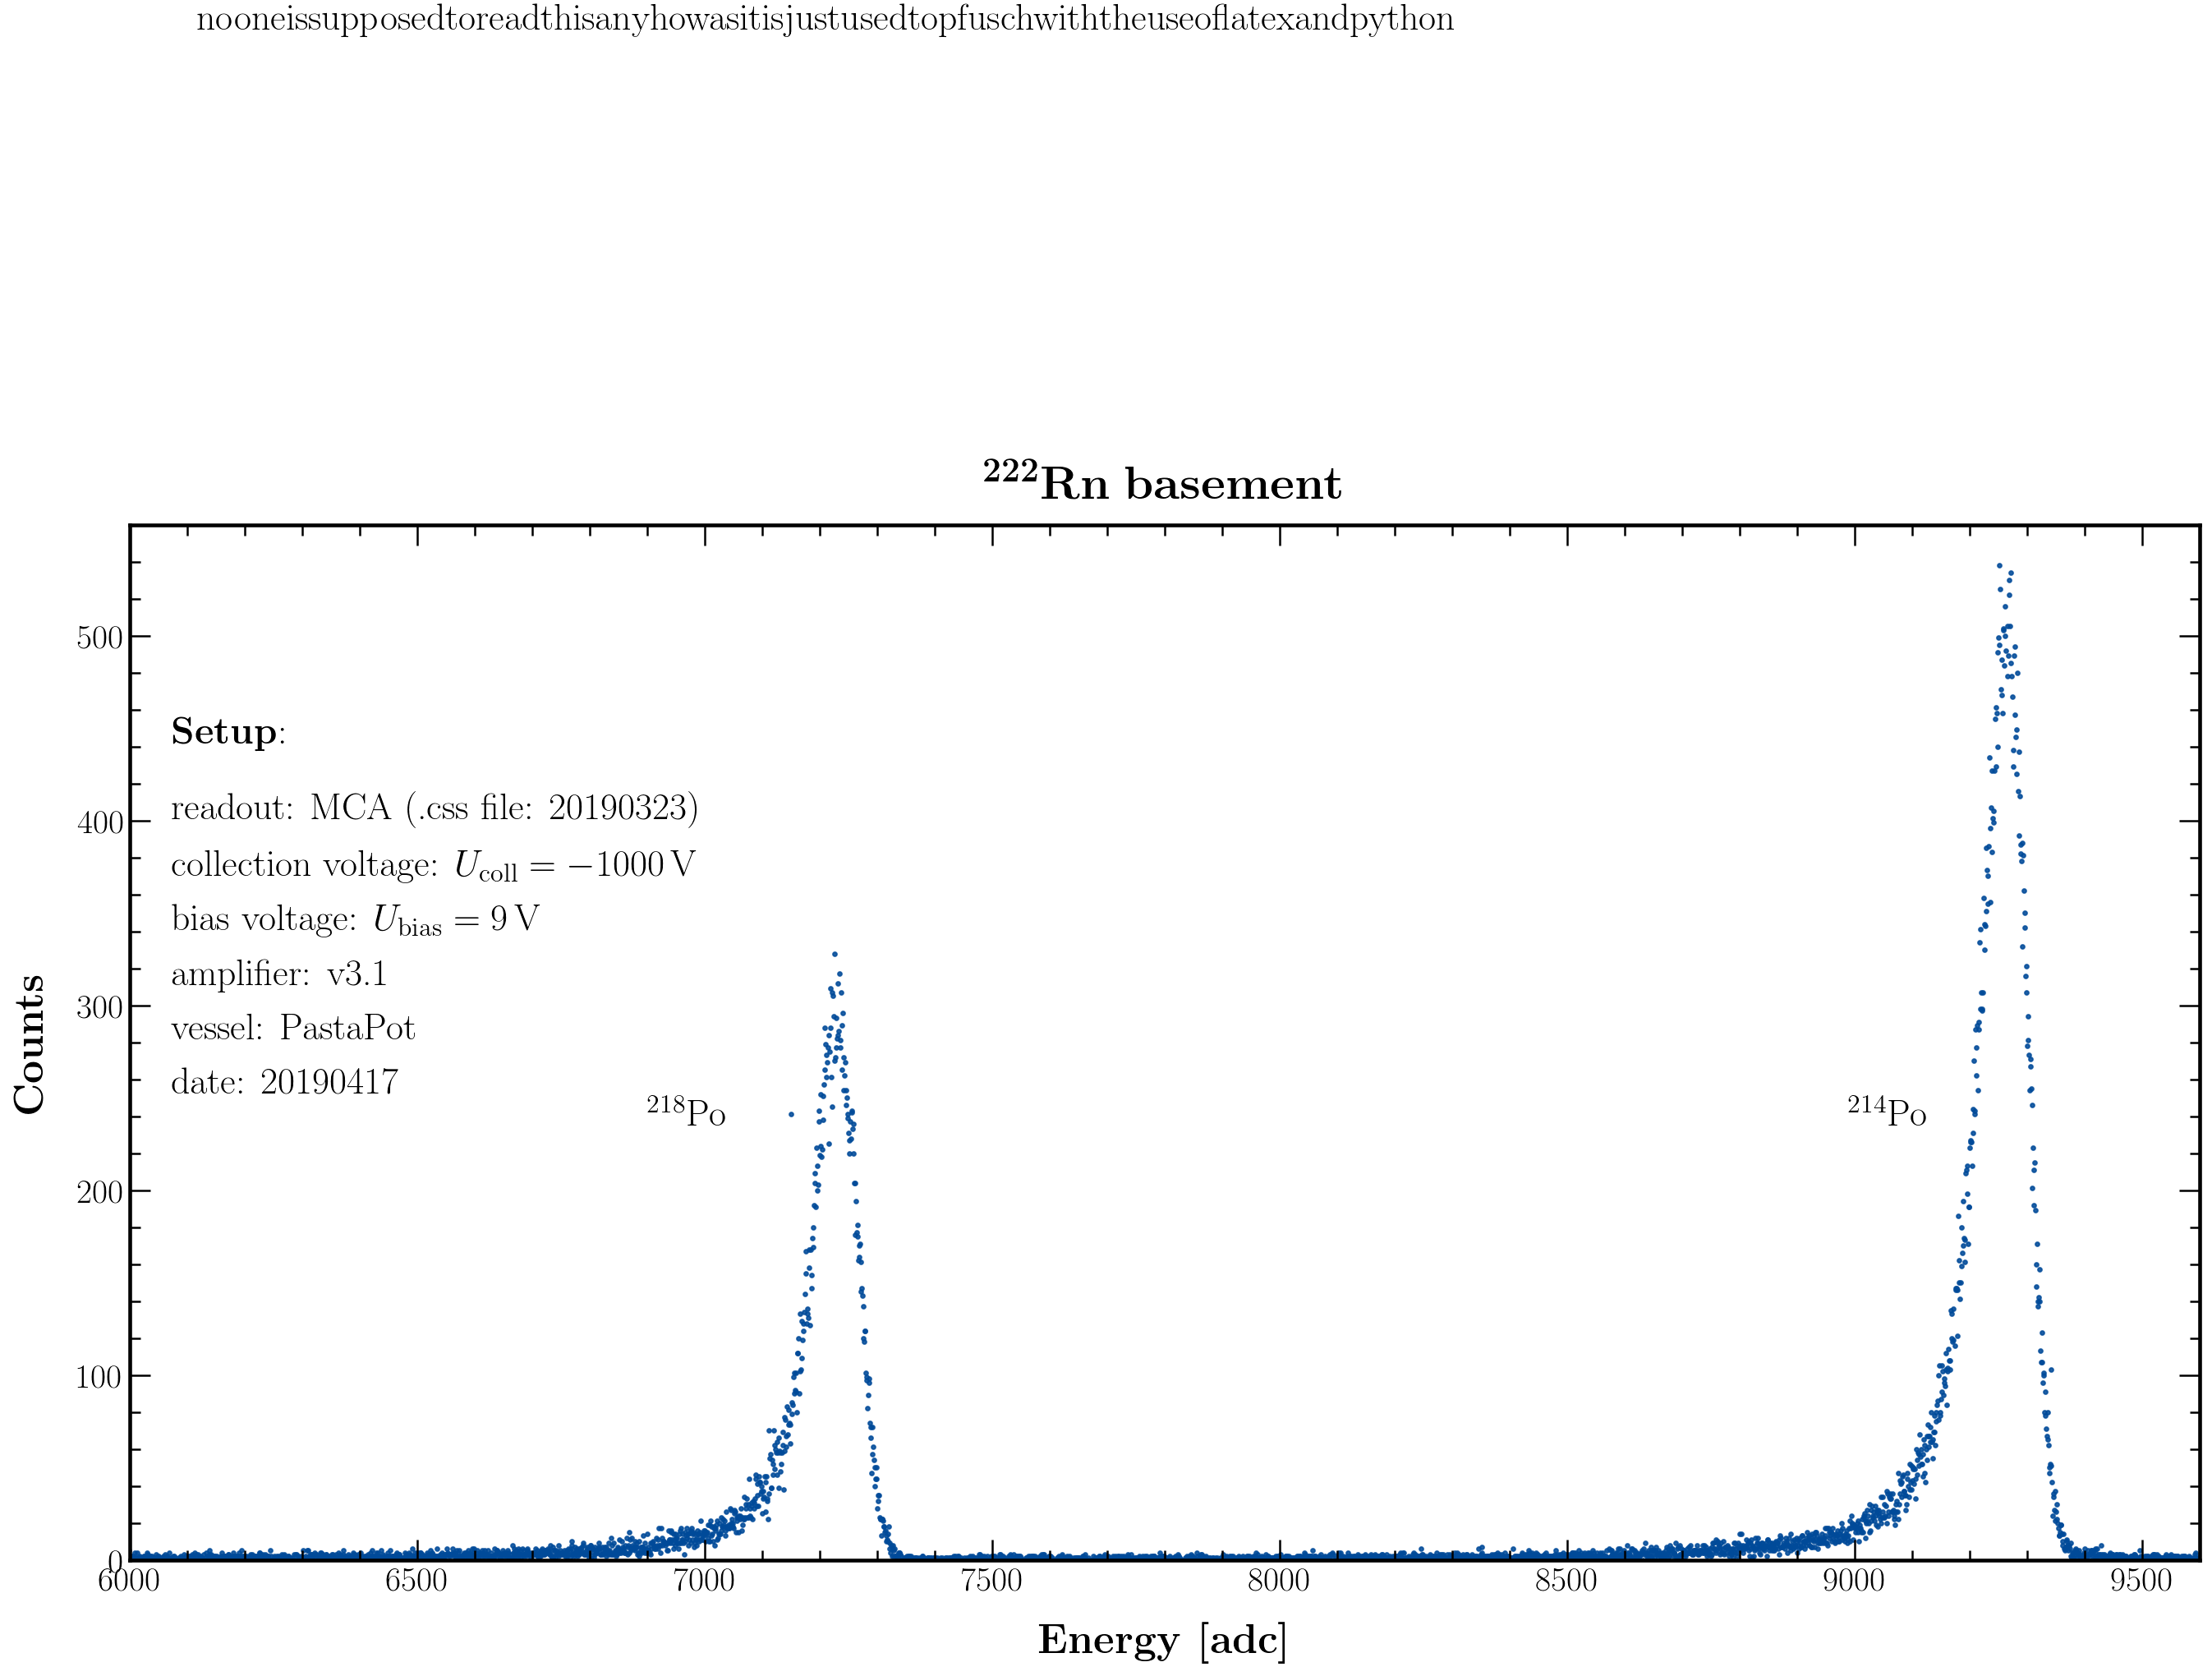

In [26]:
txt_filestring = "20190417_222Rn_basement__222Rn_spectrum_interrupt__source_basement_readout_MCA20190323_coll_1000_bias_9_vessel_PastaPot_amp_v3.1.txt"

FLAG_plot = True

FLAG_fits = False
FLAG_text = True
FLAG_legend = False
FLAG_plot_residual_canvas = False
FLAG_save = False


##################################################################################
###   Loading the .txt File.
##################################################################################

file = np.load(save_and_get_histogram_data_as_np_array_from_file(filestring=txt_filestring))



##################################################################################
###   Fitting
##################################################################################

if FLAG_fits == True:

    ### Gaussian fit.
    #### Fitting.
    #popt_gauss, pcov_gauss = fit_range_function(x=file["adc_channel"].tolist(),y=file["counts"].tolist(),x_min=7300, x_max=7900, function=gauss_function, guess=(1,7300,100))
    #### Generating plottable lists.
    #gauss_fit_x_values, gauss_fit_y_values = get_function_values_for_plot(x_min=6000, x_max=9000, stepwidth=1, function=gauss_function, A=popt_gauss[0], mu=popt_gauss[1], sigma=popt_gauss[2])
    #### Reading out fit parameters.
    #gauss_fit_mu = round(popt_gauss[1],1)
    #gauss_fit_sigma = round(popt_gauss[2],1)

    ### Double Crystal Ball fit.
    #### Fitting.
    popt_qcb, pcov_qcb = fit_range_function(x=file["adc_channel"].tolist(),y=file["counts"].tolist(),x_min=2000, x_max=9600, function=doub_crystal_ball_function_vec_self, guess=(7220, 180, 1, 1, 125, 9290, 180, 1, 1, 160, 7220, 180, 1, 1, 125, 7220, 180, 1, 1, 125))
    #### Generating plottable data lists.
    qcb_fit_x_values, qcb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9600, stepwidth=1, function=doub_crystal_ball_function, mu_0=popt_qcb[0], sigma_0=popt_qcb[1], alpha_0=popt_qcb[2], n_0=popt_qcb[3], N_0=popt_qcb[4], mu_1=popt_qcb[5], sigma_1=popt_qcb[6], alpha_1=popt_qcb[7], n_1=popt_qcb[8], N_1=popt_qcb[9])
    ##### 218Po Peak
    qcb_fit_mu_0 = round(popt_qcb[0],1)
    qcb_fit_sigma_0 = round(popt_qcb[1],1)
    qcb_fit_alpha_0 = round(popt_qcb[2],1)
    qcb_fit_n_0 = round(popt_qcb[3],1)
    qcb_fit_N_0 = round(popt_qcb[4],1)
    print(qcb_fit_mu_0)
    ##### 214Po Peak
    qcb_fit_mu_1 = round(popt_qcb[5],1)
    qcb_fit_sigma_1 = round(popt_qcb[6],1)
    qcb_fit_alpha_1 = round(popt_qcb[7],1)
    qcb_fit_n_1 = round(popt_qcb[8],1)
    qcb_fit_N_1 = round(popt_qcb[9],1)
    print(qcb_fit_mu_1)
    
    #### Generating single Crystal Ball data.
  #  Ra226_cb_fit_x_values, Ra226_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
  #  Rn222_cb_fit_x_values, Rn222_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9000, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)
    Po218_cb_fit_x_values, Po218_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9600, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
    Po214_cb_fit_x_values, Po214_cb_fit_y_values = get_function_values_for_plot(x_min=1000, x_max=9600, stepwidth=1, function=crystal_ball_function, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)

    ### Generating single Gaussian data
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_0, A=5, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_0, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0, alpha=qcb_fit_alpha_0, n=qcb_fit_n_0, N=qcb_fit_N_0)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Po218_x_values, gauss_Po218_y_values = get_function_values_for_plot(x_min=1000, x_max=9600, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_0, sigma=qcb_fit_sigma_0)
    small_gauss_value_at_peak = gauss_function(x=qcb_fit_mu_1, A=5, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1)
    crystal_ball_value_at_peak = crystal_ball_function(x=qcb_fit_mu_1, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1, alpha=qcb_fit_alpha_1, n=qcb_fit_n_1, N=qcb_fit_N_1)
    scaling_factor = crystal_ball_value_at_peak/small_gauss_value_at_peak
    gauss_Po214_x_values, gauss_Po214_y_values = get_function_values_for_plot(x_min=1000, x_max=9600, stepwidth=1, function=gauss_function, A=scaling_factor*5, mu=qcb_fit_mu_1, sigma=qcb_fit_sigma_1)

    ### Generating residual data
    res_x_data = []
    res_y_data = []
    for i in range(len(file["adc_channel"])):
        res_x_data.append(file["adc_channel"][i])
        res_y_data.append(file["counts"][i]-doub_crystal_ball_function(x=file["adc_channel"][i], mu_0=qcb_fit_mu_0, sigma_0=qcb_fit_sigma_0, alpha_0=qcb_fit_alpha_0, n_0=qcb_fit_n_0, N_0=qcb_fit_N_0, mu_1=qcb_fit_mu_1, sigma_1=qcb_fit_sigma_1, alpha_1=qcb_fit_alpha_1, n_1=qcb_fit_n_1, N_1=qcb_fit_N_1))


        
        
        
##################################################################################
###   Plotting.
##################################################################################

if FLAG_plot == True:

    #######################################################################################################################################
    ###   Defining Figure and Frame
    #######################################################################################################################################
    
    fig=plt.figure(figsize=(21, 10.5), dpi=150)  # <----- The number specified within "figsize=()" correspond to the size of the final image in inches. Correspondingly the dpi (dots per inch) value is setting the resolution of your figure.
    if FLAG_plot_residual_canvas == True:
        frame1=fig.add_axes((.1,.3,.8,.6)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))
    else: 
        frame1=fig.add_axes((.1,.1,.8,.8)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))

    #######################################################################################################################################
    ###   Plotting Data
    #######################################################################################################################################
    
    ### Plotting histogram, scatter plot or line plot.
    #plt.hist2d(file_a["number_of_electrons"], file_a["S1_PE"], bins=[142,40], range=[[0,142],[0.5,40]], cmin=1, norm=LogNorm(), cmap=plt.cm.jet)
    #plt.scatter(file["S1_PE"], file["S2_PE"], marker="o", c="cyan", alpha=1, label="equally distributed ER events") # alpha = 0.002    
    #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Quadruple Crystal Ball Fit")
        
    ### Plotting the data itself.
    plt.scatter(file["adc_channel"], file["counts"], marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None, label="$^{226}\mathrm{Ra}$ Spectrum Data")
    
    if FLAG_fits == True:
        
        ### Plotting the quadruple Crystal Ball fit.
        #plt.plot(qcb_fit_x_values, qcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Quadruple Crystal Ball Fit")
    
        ### Plotting the Crystal Ball curves resulting from the quadruple Crystal Ball fit.
        #plt.plot(Ra226_cb_fit_x_values, Ra226_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{226}\mathrm{Ra}$")
        #plt.plot(Rn222_cb_fit_x_values, Rn222_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{222}\mathrm{Rn}$")
        plt.plot(Po218_cb_fit_x_values, Po218_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{218}\mathrm{Po}$")
        plt.plot(Po214_cb_fit_x_values, Po214_cb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Curve: $^{214}\mathrm{Po}$")
    
        ### Plotting the relevant gaussians resulting from the quadruple Crystal Ball fit.
        plt.plot(gauss_Po218_x_values, gauss_Po218_y_values, marker=",", linewidth=5, c="blue", alpha=0.75, label="Gaussian Curve: $^{218}\mathrm{Po}$")
        plt.plot(gauss_Po214_x_values, gauss_Po214_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Curve: $^{214}\mathrm{Po}$")
    
        ### Plotting a gaussian fit for the 214Po Peak (the fit is done only for the right half).
        #plt.plot(gauss_fit_x_values, gauss_fit_y_values, marker=",", linewidth=5, c="red", alpha=0.75, label="Gaussian Fit: $\mu_\mathrm{G}=\,$" +str(gauss_fit_mu) +"$,\,\,\sigma_\mathrm{G}=\,$" +str(gauss_fit_sigma))
     
    
    #######################################################################################################################################
    ###   Axes Settings
    #######################################################################################################################################
    
    ### Title
    title_string = "$\\boldsymbol{^{222}\mathrm{Rn}}$ \\textbf{basement}"
    plt.title(title_string, fontsize=28, pad=15)
    
    ### Axes ---> Labels
        #plt.xlabel("\\textbf{$\\boldsymbol{F=ma}$}", fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    xaxisstring = "\\textbf{Energy }$\\boldsymbol{[\\mathrm{adc}]}$"
    yaxisstring = "\\textbf{Counts}"
    if FLAG_plot_residual_canvas == True:
        plt.xlabel(xaxisstring, fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    else:
        plt.xlabel(xaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    plt.ylabel(yaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
    
    ### Axes ---> Formatting
    axes = plt.gca()
    axes.tick_params(axis='both')
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)
        
    ### Axes ---> Range  
    plt.xlim(6000,9600)
    plt.ylim(0,560)
    #plt.ylim(100,2500)
    #plt.yscale("log")
    
    ### Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='major', direction='in', labelsize=20, top=True, right=True, width=1.2, length=12)
    if FLAG_plot_residual_canvas == True:
        plt.setp(axes.get_xticklabels(), visible=False)
    #plt.yticks([1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0, 5.0])
    #plt.xticks([])
    
    ### Axes ---> Shading
    #axes.axvspan(0, 23.0, alpha=0.5, color='0.8')
    
    ### Axes ---> Horizontal/Vertical Lines
    #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
    #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)

    #######################################################################################################################################
    ###   Colorbar
    #######################################################################################################################################
    
    #cbar = plt.colorbar() #label="Counts") #, fontsize=28)
    #cbar.set_label(label="Counts", fontsize=24, labelpad=-105)
    #cbar.outline.set_linewidth(2.2)
    #cbar.ax.tick_params(labelsize=20)

    #######################################################################################################################################
    ###   Plot Size
    #######################################################################################################################################
    
    # For a figure optimized for 4:3 ratio.
    plt.subplots_adjust(left=0.10, right=0.80, top=0.93, bottom=0.10)
    # For a figure optimized for 16:9 ratio.
    #plt.subplots_adjust(left=0.05, right=1.10, top=0.93, bottom=0.10)

    #######################################################################################################################################
    ###   Legend
    #######################################################################################################################################
    
    if FLAG_legend == True:
    
        if FLAG_plot_residual_canvas == True:
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [5,0,1,3,2,4]
            leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=3, bbox_to_anchor=(0.69,0.51), fontsize = 18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
        else:
            leg = plt.legend(loc=3, bbox_to_anchor=(0.68,0.71), fontsize=18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
            
        for line in leg.get_lines(): # enumerated
            line.set_linewidth(4)
        leg.get_frame().set_linewidth(2.5)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    #######################################################################################################################################
    ###   Text
    #######################################################################################################################################
    
        
    plt.text(0.25, 0.42, "$^{218}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
    plt.text(0.83, 0.42, "$^{214}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
        
    if FLAG_text == True:
        if FLAG_plot_residual_canvas == True:
            plt.text(0.02, 0.30, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
        else:
            plt.text(0.02, 0.450, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)
        
    #######################################################################################################################################
    ###   Residual Canvas
    #######################################################################################################################################
    
    if FLAG_plot_residual_canvas == True:
        frame2=fig.add_axes((.1,.1,.8,.2))
    
        # Plotting
        plt.scatter(res_x_data, res_y_data, marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None)#, label="Residuals")
    
        # Axes Settings
        plt.ylabel("\\textbf{Residuals}", fontsize=24, labelpad = 9)   # <--- Specifying the x-axis label along with its (self explaining) properties.
        axes2 = plt.gca()
        axes2.tick_params(axis='both')
        for axis in ['top','bottom','left','right']:
            axes2.spines[axis].set_linewidth(2.2)
        ## Axes ---> Range  
        plt.xlim(1000,8500)
        plt.ylim(-150,+150)
        #plt.yscale("log")
        # Axes ---> Ticks
        axes2.xaxis.set_minor_locator(AutoMinorLocator(5))
        #plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
        axes2.yaxis.set_minor_locator(AutoMinorLocator(5))
        plt.tick_params(which='major', direction='in', labelsize=20, top=True, right=True, width=1.2, length=12)
        plt.yticks([-100,0,100])
        #plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
        # Axes ---> Shading
        #axes.axvspan(0, 23.0, alpha=0.5, color='0.8')
        # Axes ---> Horizontal/Vertical Lines
        #axes.axhline(y=1.0, xmin=0, xmax=60, color="black", linestyle="--", linewidth=0.5)
        #axes.axvline(x=23.0, ymin=0, ymax=6, color="black", linestyle="--", linewidth=0.5)
        axes2.axhline(y=0.0, xmin=0, xmax=10000, color="black", linestyle="--", linewidth=2.0)
        
        
        
    
        
        ### Printing Analysis Results
    print("Fit Data for the 218Po Peak: mu_0={}adc, sigma_0={}adc, alpha_0={}, n_0={}, N_0={}".format(qcb_fit_mu_0, qcb_fit_sigma_0, qcb_fit_alpha_0, qcb_fit_n_0, qcb_fit_N_0))
    print("Fit Data for the 214Po Peak: mu_1={}adc, sigma_1={}adc, alpha_1={}, n_1={}, N_1={}".format(qcb_fit_mu_1, qcb_fit_sigma_1, qcb_fit_alpha_1, qcb_fit_n_1, qcb_fit_N_1))
    
    
    #######################################################################################################################################
    ###   Saving
    #######################################################################################################################################
    
    if FLAG_save == True:
        save_string = "spectrum"
        format_string = ".png"
        fig.savefig("../../MCA/Measurements/" +get_runstring(filestring=txt_filestring) +"/" +get_runstring(filestring=txt_filestring) +"__" +get_measurementstring(filestring=txt_filestring) +"__" +save_string +format_string)

### Resolution Comparison

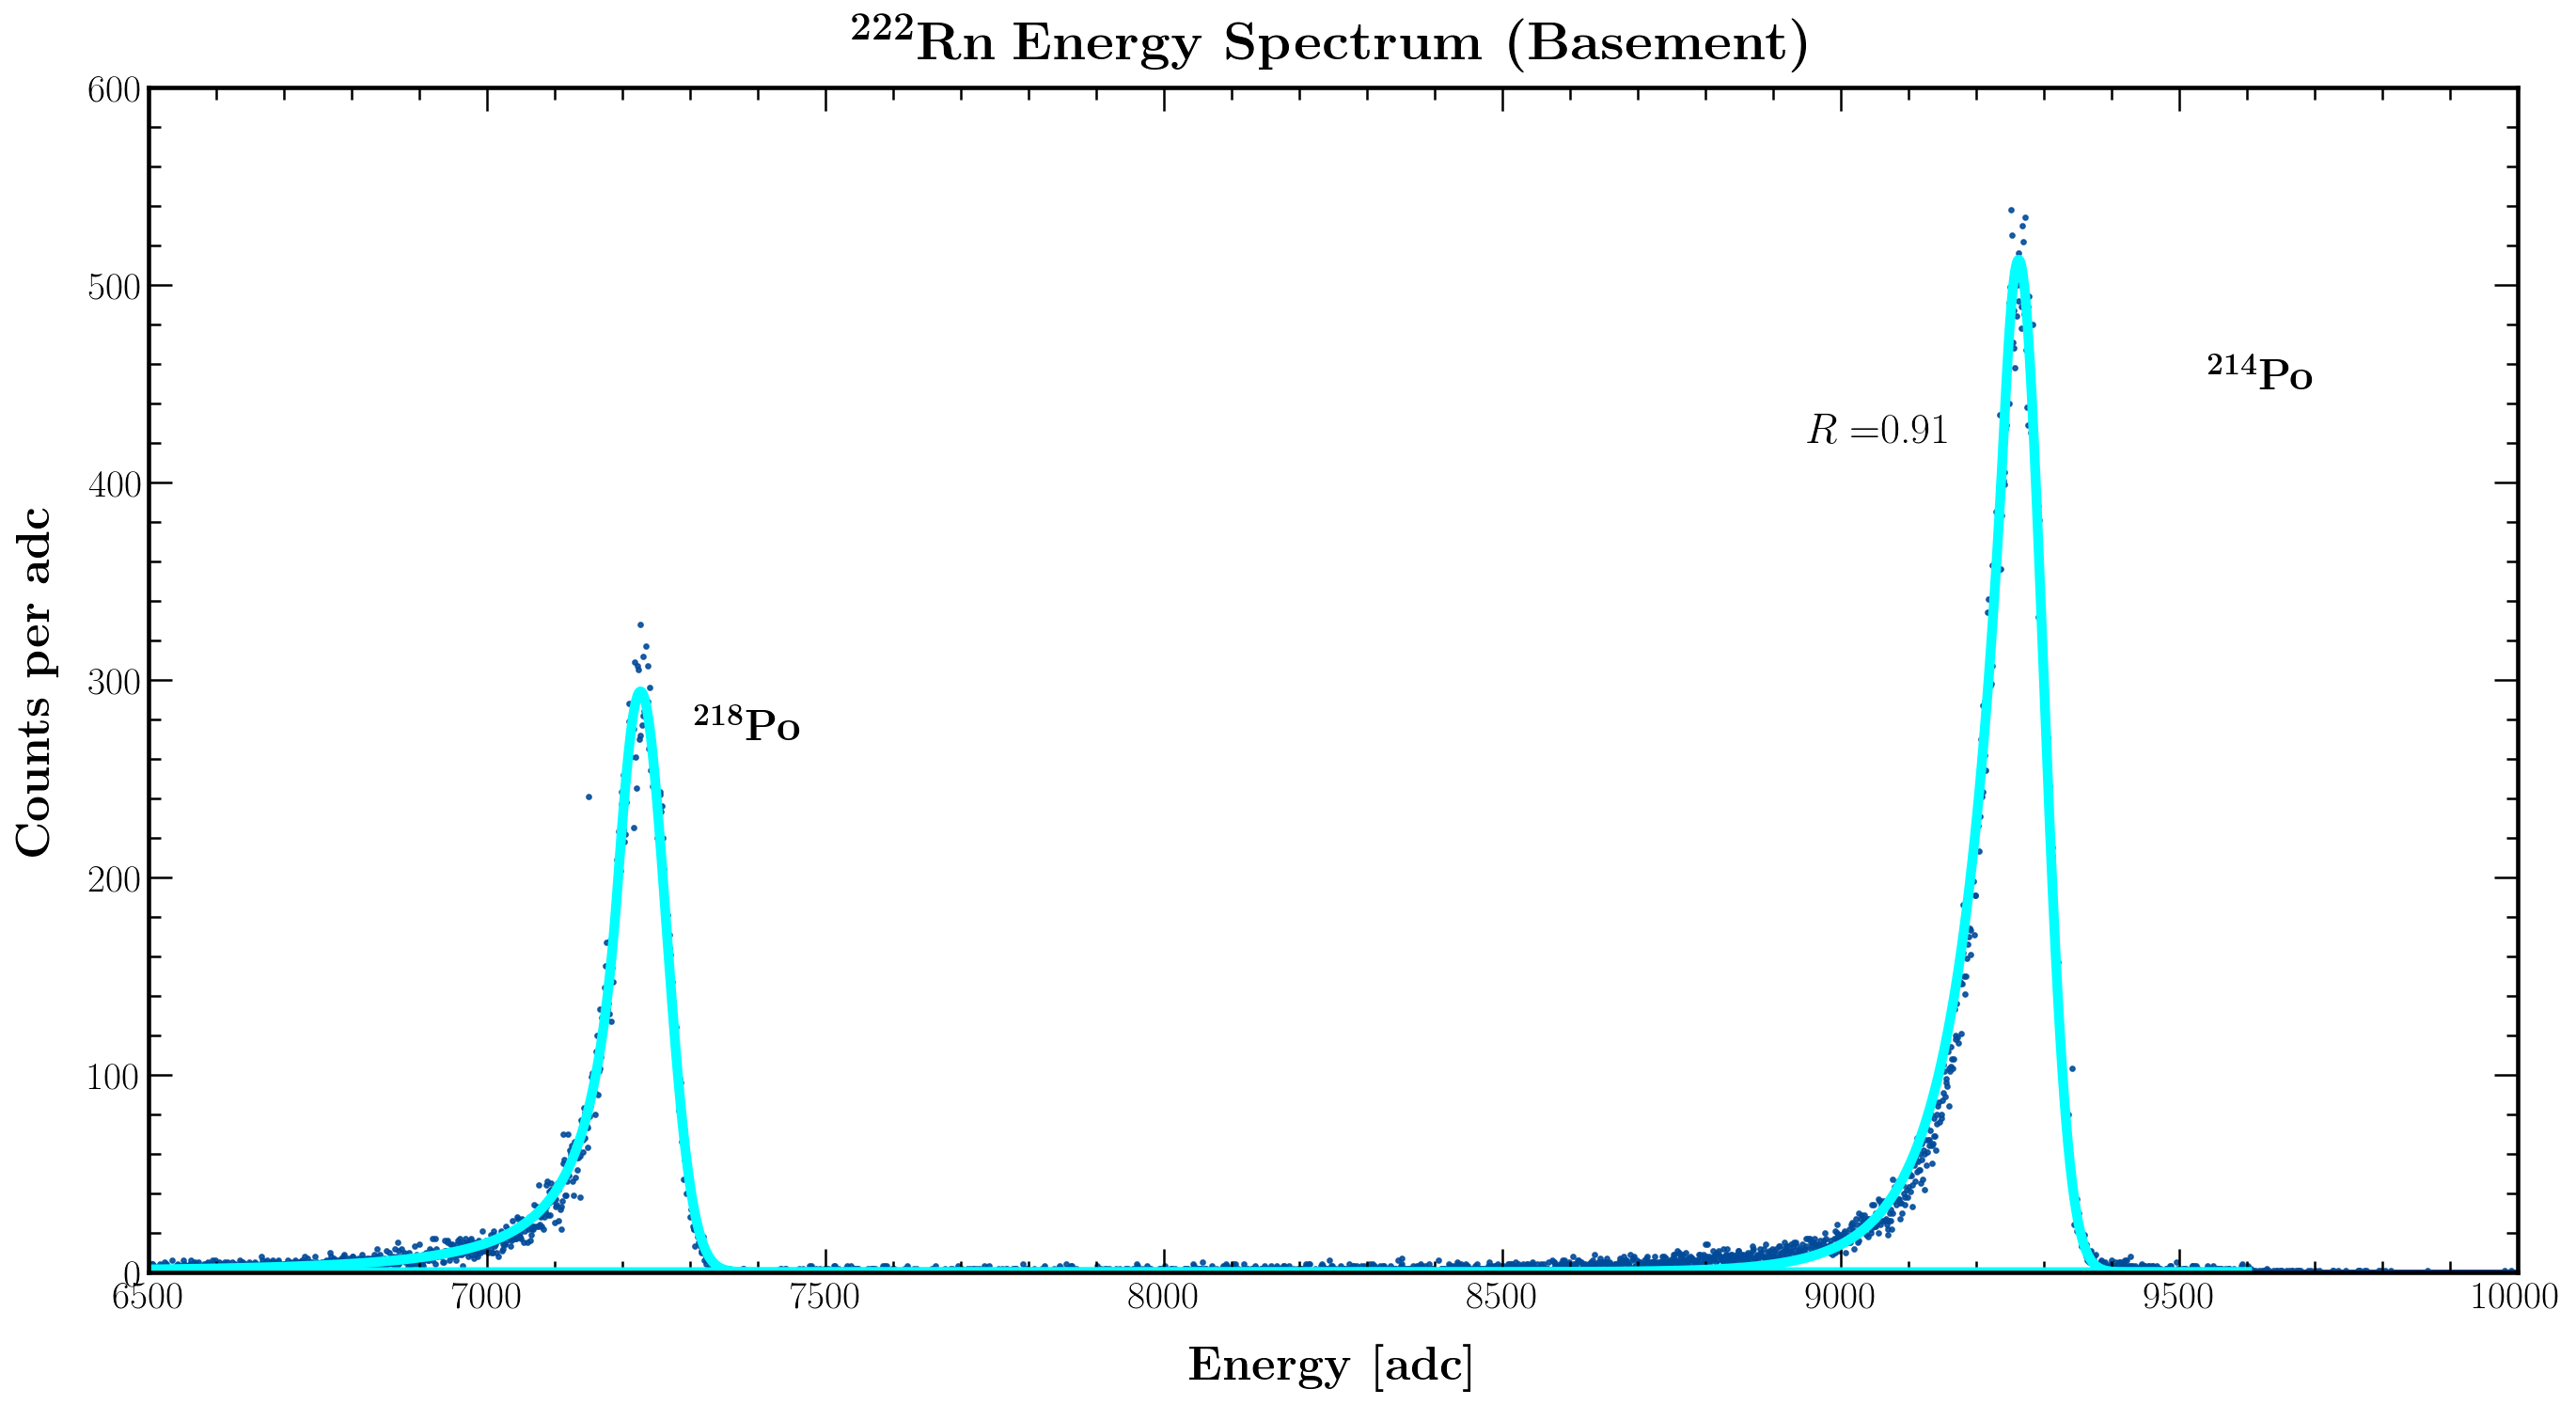

In [43]:
##################################################################################
###   Plotting.
##################################################################################

FLAG_fit_data = True
FLAG_fit_heidelberg = False
FLAG_text = False
FLAG_save = True


#######################################################################################################################################
###   Defining Figure and Frame
#######################################################################################################################################
        
fig=plt.figure(figsize=(21, 10.5), dpi=150)  ### <----- The number specified within "figsize=()" correspond to the size of the final image in inches. Correspondingly the dpi (dots per inch) value is setting the resolution of your figure.
frame1=fig.add_axes((.1,.1,.8,.8)) ### <----- This specifies a canvas within the defined figure. The argument syntax (quantities relative to the figure x and y dimensions respectively) is as follows: ("x position of the lower lefthand corner", "y position of the lower lefthand corner", "size in x direction", "size in y direction"). A usual plot is generated with the default values: frame1=fig.add_axes((0.1,0.1,0.8,0.8))



#######################################################################################################################################
###   Plotting Data, Fits and also the Heidelberg Fits
#######################################################################################################################################
    
### Data:
plt.scatter(file["adc_channel"], file["counts"], marker="o", s=5, c="#004A99", alpha=0.85, linewidth=None, label="$^{222}\mathrm{Rn}$ Spectrum Data")

### Data Fit
if FLAG_fit_data == True:
    # 218Po peak
    plt.plot(Po218_dcb_fit_x_values, Po218_dcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Crystal Ball Fit")
    #plt.plot(Po218_dcb_fit_x_values, Po218_dcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Crystal Ball Fit: $^{218}\mathrm{Po}$")
    # 214Po peak
    plt.plot(Po214_dcb_fit_x_values, Po214_dcb_fit_y_values, marker=",", linewidth=5, c="cyan", alpha=1, label="Crystal Ball Fit: $^{214}\mathrm{Po}$")

### Heidelberg Fit
    if FLAG_fit_heidelberg == True:
        # 218Po peak
        plt.plot(Po218_tcb_fit_x_values, Po218_tcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Fit (HD)")
        #plt.plot(Po218_tcb_fit_x_values, Po218_tcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Fit (HD): $^{218}\mathrm{Po}$")
        # 214Po peak
        plt.plot(Po214_tcb_fit_x_values, Po214_tcb_fit_y_values, marker=",", linewidth=5, c="purple", alpha=0.75, label="Crystal Ball Fit (HD): $^{214}\mathrm{Po}$")


        
#######################################################################################################################################
###   Axes Settings
#######################################################################################################################################
    
### Title
title_string = "$\\boldsymbol{^{222}\mathrm{Rn}}$ \\textbf{Energy Spectrum (Basement)}"
plt.title(title_string, fontsize=28, pad=15)
    
### Axes ---> Labels
#plt.xlabel("\\textbf{$\\boldsymbol{F=ma}$}", fontsize=24, labelpad = 186)   # <--- Specifying the x-axis label along with its (self explaining) properties.
xaxisstring = "\\textbf{Energy }$\\boldsymbol{[\\mathrm{adc}]}$"
yaxisstring = "\\textbf{Counts per adc}"
plt.xlabel(xaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.
plt.ylabel(yaxisstring, fontsize=24, labelpad = 14)   # <--- Specifying the x-axis label along with its (self explaining) properties.

### Axes ---> Formatting
axes = plt.gca()
axes.tick_params(axis='both')
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)

### Axes ---> Range  
plt.xlim(6500,10000) #plt.xlim(0,8500)
plt.ylim(0,600)
#plt.ylim(100,2500)
#plt.yscale("log")

### Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=20, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='major', direction='in', labelsize=20, top=True, right=True, width=1.2, length=12)

#plt.yticks([1.0, 1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 4.0, 5.0])
#plt.xticks([])



#######################################################################################################################################
###   Plot Size
#######################################################################################################################################

# For a figure optimized for 4:3 ratio.
#plt.subplots_adjust(left=0.10, right=0.80, top=0.93, bottom=0.10)
# For a figure optimized for 16:9 ratio.
plt.subplots_adjust(left=0.05, right=1.10, top=0.93, bottom=0.10)

       

#######################################################################################################################################
###   Legend
#######################################################################################################################################

#if FLAG_fit_data == True and FLAG_fit_heidelberg == True:
 #   handles, labels = plt.gca().get_legend_handles_labels()
  #  order = [4,0,2]
   # leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=3, bbox_to_anchor=(0.42,0.37), fontsize=18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
    #for line in leg.get_lines(): # enumerated
    #    line.set_linewidth(4)
   # leg.get_frame().set_linewidth(2.5)
    #for lh in leg.legendHandles: 
     #   lh.set_alpha(1)

#elif FLAG_fit_data == True:
 #   leg = plt.legend(loc=3, bbox_to_anchor=(0.68,0.71), fontsize=18, frameon=True, shadow=False, edgecolor='black', fancybox=False)
  #  for line in leg.get_lines(): # enumerated
   #     line.set_linewidth(4)
    #leg.get_frame().set_linewidth(2.5)
    #for lh in leg.legendHandles: 
     #   lh.set_alpha(1)

#else:
 #   print("No legend generated.")






#######################################################################################################################################
###   Text
#######################################################################################################################################

plt.text(0.23, 0.45, "$\\boldsymbol{^{218}\mathrm{Po}}$", fontsize=22, transform = axes.transAxes)
#plt.text(0.83, 0.42, "$^{214}\mathrm{Po}$", fontsize=22, transform = axes.transAxes)
plt.text(0.70, 0.70, "$\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,\\,$" +"$\\boldsymbol{^{214}\mathrm{Po}}$" +"\\\\[0.4cm]" +"$\\,\\,\\,\\,\\,R=$" +"{:.2f}".format(R), fontsize=22, transform = axes.transAxes)  

if FLAG_text == True:
    plt.text(0.02, 0.450, write_parameters_to_canvas_text_block(filestring=txt_filestring), fontsize=22, transform = axes.transAxes)



#######################################################################################################################################
###   Saving
#######################################################################################################################################

if FLAG_save == True:
    save_string = "Resolution_Comparison"
    format_string = ".png"
    try:
        fig.savefig("Measurements/" +get_runstring(filestring=txt_filestring) +"/" +get_runstring(filestring=txt_filestring) +"__" +get_measurementstring(filestring=txt_filestring) +"__" +save_string +format_string)
    except:
        fig.savefig("MonXe/MCA/Measurements/" +get_runstring(filestring=txt_filestring) +"/" +get_runstring(filestring=txt_filestring) +"__" +get_measurementstring(filestring=txt_filestring) +"__" +save_string +format_string)
